In [1]:
input_dataset_path = r'C:\Users\RUPavlovAl1\Desktop\Python projects\NPF tool\NPF3_INPUT_data_Template.xlsx'

# START

## Import libraries and read raw data

In [2]:
# import libraries and define useful functions

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KDTree
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

def get_full_df_info(df):
    display(df.tail())
    display(df.info())
    display(df.describe(include='all'))
    
result = 'Done'

In [3]:
# import raw data

variables = pd.read_excel(input_dataset_path, sheet_name='Variables', index_col=0, usecols=[0, 1])
variables.index = variables.index.map(str.lower)

assumptions = pd.read_excel(input_dataset_path, sheet_name='Assumptions', index_col=0)
assumptions.columns = map(lambda x: str(x).lower(), assumptions.columns)
assumptions = assumptions.head(1)

wrk_npf_input = pd.read_excel(input_dataset_path, sheet_name='Data')
wrk_npf_input = wrk_npf_input.dropna(thresh=len(wrk_npf_input) * 0.75, axis=1)
wrk_npf_input.columns = map(lambda x: str(x).lower(), wrk_npf_input.columns)
wrk_npf_input['date'] = pd.to_datetime(wrk_npf_input['date'], format='%b %Y')
wrk_npf_input = wrk_npf_input.rename(columns={'distribution': 'wei_distrib'})

In [4]:
# define variables

only_new_launches_included = variables.loc['only new launches included'].Value.lower()
launch_month = variables.loc['launch month'].Value
number_of_similar = int(variables.loc['number of similar'].Value)

num_features = [column for column in list(wrk_npf_input.columns) if 'num' in column]
num_weight = 0.5

cat_features = [column for column in list(wrk_npf_input.columns) if 'cat' in column]

cat_weight = 0.5 if variables.loc['categorical features importance'].Value == 'Default (More like filtering)' else 0.2
    
# define KNN variables
default_num_features = ['mean_price', 'mean_wei_distrib_1_4m',
                        'mean_wei_distrib_5_8m', 'mean_wei_distrib_9_12m']
default_num_weights = [2, 1, 1, 1]

default_num_weights = dict(zip(default_num_features, default_num_weights))

num_weights = {}
for num_feature in num_features:
    num_weights[num_feature] = num_weight

cat_weights = {}
for cat_feature in cat_features:
    cat_weights[cat_feature] = cat_weight

my_feat_weights = default_num_weights | num_weights | cat_weights

feature_names = {}
for feature in num_features + cat_features:
    feature_names[feature] = variables.loc[feature].Value

assumptions[default_num_features[1:]] = assumptions[default_num_features[1:]] / 100
assumptions = assumptions[default_num_features + num_features + cat_features]

assum_cat_features = {}
for assum_cat_feature in cat_features:
    assum_cat_features[assum_cat_feature] = assumptions[assum_cat_feature][0]

In [5]:
# change category features to type string
wrk_npf_input[cat_features] = wrk_npf_input[cat_features].astype(str)

# get_full_df_info(wrk_npf_input)

# FINDING NEW PRODUCT LAUNCHES

In [6]:
# get positive sales, min max dates and drop duplicates

actuals_prep = wrk_npf_input.copy()

# get positive sales and filter NaN SKU
actuals_prep = actuals_prep[actuals_prep['sales'] > 0]

actuals_prep = actuals_prep.dropna(subset=['product_id'])
actuals_prep = actuals_prep[(actuals_prep['product_id'] != 'SENSITIVE')
                            & (actuals_prep['product_id'] != 'NA')
                            & (actuals_prep['product_id'] != '')
                            & (actuals_prep['product_id'] != ' ')]

max_data_date = actuals_prep['date'].max()
if only_new_launches_included == 'YES':
    min_data_date = '2018-01-01'
else:
    min_data_date = actuals_prep['date'].min()

actuals_prep = actuals_prep.drop_duplicates().reset_index(drop=True)

# get_full_df_info(actuals_prep)

In [7]:
# Get list of SKUs which:
#     a) were launched at least 2 months after first available date in data / or artificial min in case of new launches only
#     b) have at least 12 months of sales

min_launch_date = pd.to_datetime(min_data_date) + pd.DateOffset(months=2)
min_months_history = 12

new_product_filter_prep = actuals_prep[['product_id', 'date']].copy()
new_product_filter_prep = new_product_filter_prep.groupby('product_id').agg(launch_date_sku=('date', 'min'),
                                                                            max_date=('date', 'max')).reset_index()

new_product_filter_prep['life_span_sku'] = new_product_filter_prep.apply(lambda row: len(pd.period_range(start=row['launch_date_sku'],
                                                                                                         end=row['max_date'], freq='M')), axis=1)

new_product_filter_prep = new_product_filter_prep.loc[(new_product_filter_prep['launch_date_sku'] >= min_launch_date)
                                                      & (new_product_filter_prep['life_span_sku'] >= min_months_history)]

new_product_filter_prep = new_product_filter_prep.drop(
    ['max_date'], axis=1).reset_index(drop=True)

# get_full_df_info(new_product_filter_prep)

In [8]:
test_level_of_output = actuals_prep[[
    'product_id', 'chan_cust_regi', 'date', 'sales']].copy()

test_level_of_output['level_of_output_launch_date'] = test_level_of_output.groupby(
    ['product_id', 'chan_cust_regi'])['date'].transform('min')

# pick products from new_product_filter_prep and choose 12 months from level_of_output_launch_date
test_level_of_output = test_level_of_output.loc[(test_level_of_output['product_id'].isin(new_product_filter_prep['product_id'].tolist()))
                                                & (test_level_of_output['date'] <= test_level_of_output['level_of_output_launch_date'] + pd.DateOffset(months=11 + 1))].reset_index(drop=True)


# get_full_df_info(test_level_of_output)

In [9]:
# for each &level_of_output. check intermittency of product history
# by calculating months with sales in first min_months_history+1 months
# keep &level_of_output. with at least min_months_history out of min_months_history+1 months with sales

new_product_filter = test_level_of_output[[
    'product_id', 'chan_cust_regi', 'date', 'level_of_output_launch_date']].copy()

new_product_filter['count_months'] = new_product_filter.groupby(
    ['product_id', 'chan_cust_regi'])['date'].transform('nunique')

new_product_filter = new_product_filter.loc[(
    new_product_filter['count_months'] >= min_months_history)]

new_product_filter = new_product_filter.drop(['date'], axis=1)
new_product_filter = new_product_filter.drop_duplicates().reset_index(drop=True)


# get_full_df_info(new_product_filter)

In [11]:
actuals_filtered = actuals_prep[[
    'product_id', 'chan_cust_regi', 'date', 'sales', 'wei_distrib', 'price'] + num_features + cat_features].copy()

actuals_filtered = actuals_filtered.merge(
    new_product_filter[['product_id', 'chan_cust_regi',
                        'level_of_output_launch_date']],
    left_on=['product_id', 'chan_cust_regi'],
    right_on=['product_id', 'chan_cust_regi'],
    how='left'
)

actuals_filtered = actuals_filtered.loc[(actuals_filtered['level_of_output_launch_date'].notnull())
                                        & (actuals_filtered['date'] <= actuals_filtered['level_of_output_launch_date'] + pd.DateOffset(months=11))].reset_index(drop=True)

# get_full_df_info(actuals_filtered)

# DATA QUALITY

# DATA PREPARATION

In [10]:
actuals_filtered_output = actuals_prep[[
    'product_id', 'chan_cust_regi', 'date', 'sales', 'price', 'wei_distrib'] + num_features + cat_features].copy()

actuals_filtered_output = actuals_filtered_output.merge(
    new_product_filter[['product_id', 'chan_cust_regi',
                        'level_of_output_launch_date']],
    left_on=['product_id', 'chan_cust_regi'],
    right_on=['product_id', 'chan_cust_regi'],
    how='left'
)

actuals_filtered_output['is_new_launch'] = np.where(
    actuals_filtered_output['level_of_output_launch_date'].isnull(), 'No', 'Yes')
actuals_filtered_output = actuals_filtered_output.reset_index(drop=True)

# get_full_df_info(actuals_filtered_output)

## Seasonal decomposition

In [12]:
actuals_for_decomp = actuals_prep[['date', 'sales']].copy()

actuals_for_decomp = actuals_for_decomp.groupby('date').sum()
actuals_for_decomp = actuals_for_decomp.rename(
    columns={'sales': 'sum_sales_feature'})

# get_full_df_info(actuals_for_decomp)

In [13]:
decomp = seasonal_decompose(actuals_for_decomp, model='multiplicative')
seasonal_multipliers = pd.DataFrame(decomp.seasonal).reset_index()
seasonal_multipliers = seasonal_multipliers.rename(
    columns={'seasonal': 'seasonal_component'})
seasonal_multipliers['month'] = seasonal_multipliers['date'].dt.month
seasonal_multipliers = seasonal_multipliers.groupby(
    'month')['seasonal_component'].mean().reset_index()

# display(seasonal_multipliers)
# seasonal_multipliers.plot(x='month', y='seasonal_component')
# plt.show()

In [14]:
# handle missing values of seasonal_component

seasonal_effect_prep = seasonal_multipliers.copy().reset_index(drop=True)

months_set = set([*range(1, 13)])
df_months_set = set(seasonal_effect_prep['month'])
set_difference = months_set - df_months_set
if len(set_difference) != 0:
    for month in set_difference:
        seasonal_effect_prep.loc[len(seasonal_effect_prep)] = [month, 1]

# seasonal_effect_prep

## DESEASONALIZATION OF TIME SERIES

In [15]:
actuals_deflated = actuals_filtered.drop(columns=cat_features).copy()

actuals_deflated = actuals_deflated.merge(
    seasonal_effect_prep, left_on=actuals_deflated['date'].dt.month, right_on=['month'],  how='left')
actuals_deflated['sales'] = actuals_deflated['sales'] / \
    actuals_deflated['seasonal_component']
actuals_deflated['relative_month'] = actuals_deflated.apply(lambda row: len(
    pd.period_range(start=row['level_of_output_launch_date'], end=row['date'], freq='M')), axis=1)

# Binning of months to be able to catch that distribution could be build gradually

actuals_deflated['relative_month_bins'] = np.where(
    (actuals_deflated['relative_month'] >= 1) & (
        actuals_deflated['relative_month'] <= 4), '1_4m',
    np.where(
        (actuals_deflated['relative_month'] >= 5) & (
            actuals_deflated['relative_month'] <= 8), '5_8m',
        np.where(
            (actuals_deflated['relative_month'] >= 9) & (actuals_deflated['relative_month'] <= 12), '9_12m', pd.NA)))

actuals_deflated.drop(columns=['month', 'seasonal_component'], inplace=True)
actuals_deflated = actuals_deflated.reset_index(drop=True)

# get_full_df_info(actuals_deflated)

## Segmentation - multiple wei_distribs
1. prepare aggregated data for segmentation
2. calculate sum of all channel, average wei_distrib and factor to 100% wei_distrib

In [16]:
level_of_output_sales_feature_sum = actuals_prep[[
    'chan_cust_regi', 'sales', 'wei_distrib']].copy()

level_of_output_sales_feature_sum = level_of_output_sales_feature_sum.groupby('chan_cust_regi').agg(sum_level_of_output_sales_feature=('sales', 'sum'),
                                                                                                     avg_distr=('wei_distrib', 'mean')).reset_index()

level_of_output_sales_feature_sum['factor_distr'] = 100 / \
    level_of_output_sales_feature_sum['avg_distr']

level_of_output_sales_feature_sum = level_of_output_sales_feature_sum.reset_index(
    drop=True)

# level_of_output_sales_feature_sum

In [17]:
# Calculate potential sales for a 100% WEI_DISTRIB in the channel

level_of_output_sales_feature_potential = level_of_output_sales_feature_sum.copy()

level_of_output_sales_feature_potential['sales_feature_potential'] = level_of_output_sales_feature_potential[
    'sum_level_of_output_sales_feature'] * level_of_output_sales_feature_potential['factor_distr']
level_of_output_sales_feature_potential['sales_feature_potential_total'] = sum(
    level_of_output_sales_feature_potential['sales_feature_potential'])

level_of_output_sales_feature_potential = level_of_output_sales_feature_potential.reset_index(
    drop=True)

# level_of_output_sales_feature_potential

In [18]:
# Calculate weight of channel vs Total Trade

level_of_output_weight = level_of_output_sales_feature_potential.copy()

level_of_output_weight['level_of_output_weight_vs_total'] = level_of_output_weight['sales_feature_potential'] / \
    level_of_output_weight['sales_feature_potential_total']

level_of_output_weight = level_of_output_weight.reset_index(drop=True)

# level_of_output_weight

### Aggregation - CHANNEL level

In [19]:
# new channel weight calculation using 4m bins

wei_distrib_prep = actuals_deflated[[
    'product_id', 'chan_cust_regi', 'relative_month_bins', 'wei_distrib']].copy()
wei_distrib_prep = wei_distrib_prep.groupby(['product_id', 'chan_cust_regi', 'relative_month_bins']).agg(
    mean_wei_distrib=('wei_distrib', 'mean')).reset_index()

wei_distrib_prep = wei_distrib_prep.reset_index(drop=True)

# get_full_df_info(wei_distrib_prep)

In [20]:
wei_distrib_prep_transposed = wei_distrib_prep.copy()
wei_distrib_prep_transposed = wei_distrib_prep.pivot(
    index=['product_id', 'chan_cust_regi'], columns='relative_month_bins', values='mean_wei_distrib')
wei_distrib_prep_transposed = wei_distrib_prep_transposed.rename_axis(
    None, axis=1).reset_index()

wei_distrib_prep_transposed.rename(columns={'1_4m': 'mean_wei_distrib_1_4m',
                                            '5_8m': 'mean_wei_distrib_5_8m',
                                            '9_12m': 'mean_wei_distrib_9_12m'}, inplace=True)

wei_distrib_prep_transposed.reset_index(drop=True, inplace=True)

# get_full_df_info(wei_distrib_prep_transposed)

In [21]:
# Dictionary with new column names and mean aggregation to the num_feature
num_mean_agg_dict = {}
for num_feature in num_features:
    num_mean_agg_dict[num_feature + '_mean_agg'] = (f'{num_feature}', 'mean')

# Aggregation of all info to PRODUCT_ID-LEVEL_OF_OUTPUT level

segmentation_prep = actuals_deflated[[
    'product_id', 'chan_cust_regi', 'sales', 'price'] + num_features].copy()
segmentation_prep = segmentation_prep.groupby(['product_id', 'chan_cust_regi']).agg(
    sum_sales_feature=('sales', 'sum'), 
    mean_price=('price', 'mean'),
    **num_mean_agg_dict).reset_index()


segmentation_prep = segmentation_prep.merge(
    wei_distrib_prep_transposed, how='left', on=['product_id', 'chan_cust_regi'])

    segmentation_prep = segmentation_prep.merge(level_of_output_weight[['chan_cust_regi', 'level_of_output_weight_vs_total']],
                                            how='left', on='chan_cust_regi')

segmentation_prep.rename(columns={
                         'level_of_output_weight_vs_total': 'new_level_of_output_weight'}, inplace=True)

segmentation_prep['mean_wei_distrib_1_4m'] = segmentation_prep['mean_wei_distrib_1_4m'] / 100
segmentation_prep['mean_wei_distrib_5_8m'] = segmentation_prep['mean_wei_distrib_5_8m'] / 100
segmentation_prep['mean_wei_distrib_9_12m'] = segmentation_prep['mean_wei_distrib_9_12m'] / 100

segmentation_prep = segmentation_prep.reset_index(drop=True)

# get_full_df_info(segmentation_prep)

In [22]:
# Agregation to SKU(PRODUCT_ID) level

# Dictionary with new column names and mean aggregation to the num_feature
num_mean_agg_2_dict = {}
for num_feature in num_mean_agg_dict.keys():
    num_mean_agg_2_dict[num_feature + '_2'] = (f'{num_feature}', 'mean')

segmentation_prep_sku = segmentation_prep.drop('chan_cust_regi', axis=1).copy()

segmentation_prep_sku['mean_wei_distrib_1_4m'] = segmentation_prep_sku['mean_wei_distrib_1_4m'] * \
    segmentation_prep_sku['new_level_of_output_weight']
segmentation_prep_sku['mean_wei_distrib_5_8m'] = segmentation_prep_sku['mean_wei_distrib_5_8m'] * \
    segmentation_prep_sku['new_level_of_output_weight']
segmentation_prep_sku['mean_wei_distrib_9_12m'] = segmentation_prep_sku['mean_wei_distrib_9_12m'] * \
    segmentation_prep_sku['new_level_of_output_weight']
segmentation_prep_sku = segmentation_prep_sku.groupby('product_id').agg(sum_sales_feature=('sum_sales_feature', 'sum'),
                                                                         mean_price=('mean_price', 'mean'),
                                                                         mean_wei_distrib_1_4m=('mean_wei_distrib_1_4m', 'sum'),
                                                                         mean_wei_distrib_5_8m=('mean_wei_distrib_5_8m', 'sum'),
                                                                         mean_wei_distrib_9_12m=('mean_wei_distrib_9_12m', 'sum'),
                                                                        **num_mean_agg_2_dict)

segmentation_prep_sku = segmentation_prep_sku.reset_index()

# get_full_df_info(segmentation_prep_sku)

In [23]:
# Adding additional STATIC/CATEGORICAL features
if cat_features:
    static_features = actuals_filtered[['product_id'] + cat_features].copy()
    static_features = static_features.drop_duplicates(subset=['product_id']).reset_index(drop=True)
    
    # final segmentation table
    segmentation_prep_sku = segmentation_prep_sku.merge(static_features, how='left', on='product_id')
#     get_full_df_info(segmentation_prep_sku)

In [24]:
# Aggregation of all info to PRODUCT_ID-LEVEL_OF_OUTPUT level

# Dictionary with new column names and mean aggregation to the num_feature
num_mean_agg_dict = {}
for num_feature in num_features:
    num_mean_agg_dict[num_feature + '_mean_agg'] = (f'{num_feature}', 'mean')

# Aggregation of all info to PRODUCT_ID-LEVEL_OF_OUTPUT level

segmentation_prep = actuals_deflated[[
    'product_id', 'chan_cust_regi', 'sales', 'price'] + num_features].copy()
segmentation_prep = segmentation_prep.groupby(['product_id', 'chan_cust_regi']).agg(
    sum_sales_feature=('sales', 'sum'), 
    mean_price=('price', 'mean'),
    **num_mean_agg_dict).reset_index()

segmentation_prep = segmentation_prep.merge(
    wei_distrib_prep_transposed, how='left', on=['product_id', 'chan_cust_regi'])

segmentation_prep = segmentation_prep.merge(level_of_output_weight[['chan_cust_regi', 'level_of_output_weight_vs_total']],
                                            how='left', on='chan_cust_regi')

segmentation_prep.rename(columns={
                         'level_of_output_weight_vs_total': 'new_level_of_output_weight'}, inplace=True)

segmentation_prep['mean_wei_distrib_1_4m'] = segmentation_prep['mean_wei_distrib_1_4m'] / 100
segmentation_prep['mean_wei_distrib_5_8m'] = segmentation_prep['mean_wei_distrib_5_8m'] / 100
segmentation_prep['mean_wei_distrib_9_12m'] = segmentation_prep['mean_wei_distrib_9_12m'] / 100

segmentation_prep = segmentation_prep.reset_index(drop=True)

# get_full_df_info(segmentation_prep)

In [25]:
# Making structure to undestand for which months the forecast should be done
# It will be used for adding seasonality

forecast_rows = pd.period_range(start=launch_month,
                                end=pd.to_datetime(
                                    launch_month) + pd.DateOffset(months=11),
                                freq='M')

forecast_rows = pd.DataFrame({'relative_month': range(1, 13), 'date': forecast_rows})

forecast_rows['date'] = forecast_rows['date'].dt.to_timestamp()
forecast_rows['product_id'] = 'forecast'

# forecast_rows

# EXPLORE DATA

## Prepare to explore

In [26]:
# GENERAL TABLE WITH ALL CATEGORICAL/DESCRIPTIVE PRODUCT FEATURES

product_description_output = actuals_prep[[
    'product_id', 'product_name', 'manufacturer'] + cat_features].copy()
product_description_output = product_description_output.drop_duplicates(subset=['product_id']).reset_index(drop=True)

join_actuals_filtered_output = actuals_filtered_output.copy()
join_actuals_filtered_output = join_actuals_filtered_output.groupby('product_id').agg(
    min_launch_date=('level_of_output_launch_date', 'min')).reset_index()

product_description_output = product_description_output.merge(join_actuals_filtered_output[['product_id', 'min_launch_date']],
                                                              left_on=['product_id'], right_on=['product_id'],
                                                              how='left').reset_index(drop=True)

# get_full_df_info(product_description_output)

In [27]:
actuals_filtered_output['relative_month'] = actuals_filtered_output.apply(lambda row: len(pd.period_range(start=row['level_of_output_launch_date'],
                                                                                                          end=row['date'], freq='M')) if row['is_new_launch'] == 'Yes' else pd.NA, axis=1)
actuals_filtered_output = actuals_filtered_output.merge(product_description_output[['product_id', 'product_name']],
                                                        on='product_id', how='left')

# get_full_df_info(actuals_filtered_output)

In [28]:
# AGG NEW LAUNCHES OUTPUT

segmentation_prep_sku_output = segmentation_prep_sku.copy()

join_actuals_filtered_output = actuals_filtered_output[[
    'product_id', 'sales', 'relative_month']].copy()
join_actuals_filtered_output = join_actuals_filtered_output[
    join_actuals_filtered_output['relative_month'] <= 12]
join_actuals_filtered_output = join_actuals_filtered_output.groupby(
    'product_id').agg(sum_sales=('sales', 'sum')).reset_index()


segmentation_prep_sku_output = segmentation_prep_sku_output.merge(product_description_output,
                                                                  how='left',
                                                                  on='product_id').reset_index(drop=True)

segmentation_prep_sku_output.drop(columns='sum_sales_feature', inplace=True)

segmentation_prep_sku_output = segmentation_prep_sku_output.merge(
    join_actuals_filtered_output, how='left', on='product_id')

# get_full_df_info(segmentation_prep_sku_output)

In [29]:
# ACTUALS DEFLATED OUTPUT

actuals_deflated_output = actuals_deflated.copy()

actuals_deflated_output = actuals_deflated_output.merge(product_description_output,
                                                        on='product_id', how='left')

actuals_deflated_output = actuals_deflated_output.reset_index(drop=True)

# get_full_df_info(actuals_deflated_output)

In [30]:
# AGG NEW LAUNCHES PER CH OUTPUT

segmentation_prep_per_ch_output = segmentation_prep.copy()

join_actuals_filtered_output = actuals_filtered_output[[
    'product_id', 'sales', 'relative_month']].copy()
join_actuals_filtered_output = join_actuals_filtered_output[
    join_actuals_filtered_output['relative_month'] <= 12]
join_actuals_filtered_output = join_actuals_filtered_output.groupby(
    'product_id').agg(sum_sales=('sales', 'sum')).reset_index()


segmentation_prep_per_ch_output = segmentation_prep_per_ch_output.merge(product_description_output,
                                                                        how='left',
                                                                        on='product_id')

segmentation_prep_per_ch_output.drop(
    columns=['sum_sales_feature', 'new_level_of_output_weight'], inplace=True)

segmentation_prep_per_ch_output = segmentation_prep_per_ch_output.merge(join_actuals_filtered_output,
                                                                        how='left',
                                                                        on='product_id').reset_index(drop=True)

# get_full_df_info(segmentation_prep_per_ch_output)

## Explore

### Parameters specified by You - Data

In [31]:
pd.DataFrame({'Selected dataset name': input_dataset_path.rsplit('\\', 1)[-1]}, index=[0])

,Selected dataset name
0,NPF3_INPUT_data_Template.xlsx


### Parameters specified by You - General

In [32]:
pd.DataFrame({'Dashboard type': 'Explore',
              'Launch month': launch_month,
              'Selected features set': 'price wei_distrib ' + ' '.join(feature_names.values())}, index=[0])

,Dashboard type,Launch month,Selected features set
0,Explore,2023-08-01,price wei_distrib NUM_FEAT_1_NAME CAT_FEAT_1_NAME


### Your input data summary

In [33]:
pd.DataFrame({'Number of products': wrk_npf_input['product_id'].nunique()}, index=[0])

,Number of products
0,5464


### Your input data - Final filtered

In [34]:
pd.DataFrame({'Number of products': actuals_prep['product_id'].nunique(),
              'First month of history': actuals_prep['date'].min(),
              'Last month of history': actuals_prep['date'].max()}, index=[0])

,Number of products,First month of history,Last month of history
0,5425,2019-01-01,2022-01-01


### Number of new launches - Final filtered

In [35]:
pd.DataFrame({'Number of products': actuals_filtered['product_id'].nunique(),
              'First month of history': actuals_filtered['date'].min(),
              'Last month of history': actuals_filtered['date'].max()}, index=[0])

,Number of products,First month of history,Last month of history
0,921,2019-03-01,2022-01-01


### First 12 rows in the dataset

In [36]:
actuals_filtered_df = actuals_filtered.copy()
actuals_filtered_df = actuals_filtered_df.rename(columns={**feature_names})
actuals_filtered_df.head(12)

,product_id,chan_cust_regi,date,sales,wei_distrib,price,NUM_FEAT_1_NAME,CAT_FEAT_1_NAME,level_of_output_launch_date
0,P000000000000620564000000000000044880516,Total National Urban,2019-10-01,0.0002,0.05,2806.500000,1,A,2019-10-01
1,P000000000000620564000000000000044880516,Total National Urban,2019-11-01,0.0049,0.41,3308.408163,1,A,2019-10-01
2,P000000000000620564000000000000044880516,Total National Urban,2019-12-01,0.0340,0.68,3219.838235,1,A,2019-10-01
3,P000000000000620564000000000000044880516,Total National Urban,2020-01-01,0.0070,0.35,3216.242857,1,A,2019-10-01
4,P000000000000620564000000000000044880516,Total National Urban,2020-02-01,0.0027,0.23,3267.111111,1,A,2019-10-01
5,P000000000000620564000000000000044880516,Total National Urban,2020-03-01,0.0046,0.28,3289.282609,1,A,2019-10-01
6,P000000000000620564000000000000044880516,Total National Urban,2020-04-01,0.0015,0.08,3230.400000,1,A,2019-10-01
7,P000000000000620564000000000000044880516,Total National Urban,2020-05-01,0.0111,0.18,1100.936937,1,A,2019-10-01
8,P000000000000620564000000000000044880516,Total National Urban,2020-06-01,0.0043,0.10,985.186046,1,A,2019-10-01
9,P000000000000620564000000000000044880516,Total National Urban,2020-07-01,0.0004,0.06,470.250000,1,A,2019-10-01


### Last 12 rows in the dataset

In [37]:
actuals_filtered_df.tail(12)

,product_id,chan_cust_regi,date,sales,wei_distrib,price,NUM_FEAT_1_NAME,CAT_FEAT_1_NAME,level_of_output_launch_date
10979,P000000000000620564000000000000069364332,Total National Urban,2020-12-01,0.0009,0.01,6787.000000,4,D,2020-12-01
10980,P000000000000620564000000000000069364332,Total National Urban,2021-01-01,0.0038,0.03,6959.552632,4,D,2020-12-01
10981,P000000000000620564000000000000069364332,Total National Urban,2021-02-01,0.0042,0.02,6941.928571,4,D,2020-12-01
10982,P000000000000620564000000000000069364332,Total National Urban,2021-03-01,0.0057,0.03,5419.684211,4,D,2020-12-01
10983,P000000000000620564000000000000069364332,Total National Urban,2021-04-01,0.0034,0.03,4965.794118,4,D,2020-12-01
10984,P000000000000620564000000000000069364332,Total National Urban,2021-05-01,0.0050,0.03,4473.060000,4,D,2020-12-01
10985,P000000000000620564000000000000069364332,Total National Urban,2021-06-01,0.0063,0.03,4715.968254,4,D,2020-12-01
10986,P000000000000620564000000000000069364332,Total National Urban,2021-07-01,0.0084,0.03,3562.678571,4,D,2020-12-01
10987,P000000000000620564000000000000069364332,Total National Urban,2021-08-01,0.0022,0.01,5695.363636,4,D,2020-12-01
10988,P000000000000620564000000000000069364332,Total National Urban,2021-09-01,0.0030,0.02,3369.400000,4,D,2020-12-01


### Correlation with SALES

In [38]:
corr = pd.DataFrame(actuals_filtered[['price', 'wei_distrib'] + num_features].corrwith(actuals_filtered['sales'])).T
corr = corr.rename(columns={**feature_names})
corr

,price,wei_distrib,NUM_FEAT_1_NAME
0,-0.149599,0.752371,0.036997


### Correlation with each other

In [39]:
corr = pd.DataFrame(actuals_filtered[['price', 'wei_distrib'] + num_features].corr())
corr = corr.rename(columns={**feature_names})
corr = corr.rename(index={**feature_names})
corr

,price,wei_distrib,NUM_FEAT_1_NAME
price,1.000000,-0.213736,0.020433
wei_distrib,-0.213736,1.000000,0.031956
NUM_FEAT_1_NAME,0.020433,0.031956,1.000000


### Seasonality

In [40]:
seasonal_effect_prep_df = seasonal_effect_prep.copy()
seasonal_effect_prep_df['Month'] = pd.to_datetime(
    seasonal_effect_prep_df['month'], format='%m').dt.strftime('%b')

seasonal_effect_prep_df['Seasonality'] = ''

for i, row in seasonal_effect_prep_df.iterrows():
    if (row['seasonal_component'] - 1) < 0:
        seasonal_effect_prep_df.loc[i, 'Seasonality'] = f"SALES is less than average by {abs(round((row['seasonal_component'] - 1)*100, 2))}%"
    elif (row['seasonal_component'] - 1) > 0:
        seasonal_effect_prep_df.loc[i, 'Seasonality'] = f"SALES is grater than average by {abs(round((row['seasonal_component'] - 1)*100, 2))}%"
    else:
        seasonal_effect_prep_df.loc[i, 'Seasonality'] = 'SALES as average'

seasonal_effect_prep_df[['Month', 'Seasonality']]

,Month,Seasonality
0,Jan,SALES is less than average by 7.43%
1,Feb,SALES is less than average by 1.39%
2,Mar,SALES is grater than average by 9.68%
3,Apr,SALES is less than average by 7.83%
4,May,SALES is less than average by 10.13%
5,Jun,SALES is less than average by 18.13%
6,Jul,SALES is less than average by 18.44%
7,Aug,SALES is less than average by 8.16%
8,Sep,SALES is grater than average by 3.52%
9,Oct,SALES is grater than average by 12.12%


### 3 random new product SKU were selected to present results

In [41]:
new_product_sku = np.random.choice(actuals_filtered['product_id'].unique(), size=3, replace=False)
new_product_sku = pd.DataFrame({'product_id': new_product_sku})
new_product_sku.merge(product_description_output[['product_id', 'product_name']], on='product_id')

,product_id,product_name
0,P000000000000620564000000000000062626641,NA MEDU APEL`SIN 70%BCH ORNG TB 0.085KG K
1,P000000000000620564000000000000057998888,DETSKIE ISTORII(KOMMUNARKA) S KLUB.I YOG MCH S...
2,P000000000000620564000000000000068806474,VK(VERN.KACH.GK) HAPPY NEW YEAR! SHOK.OTKRYTKA...


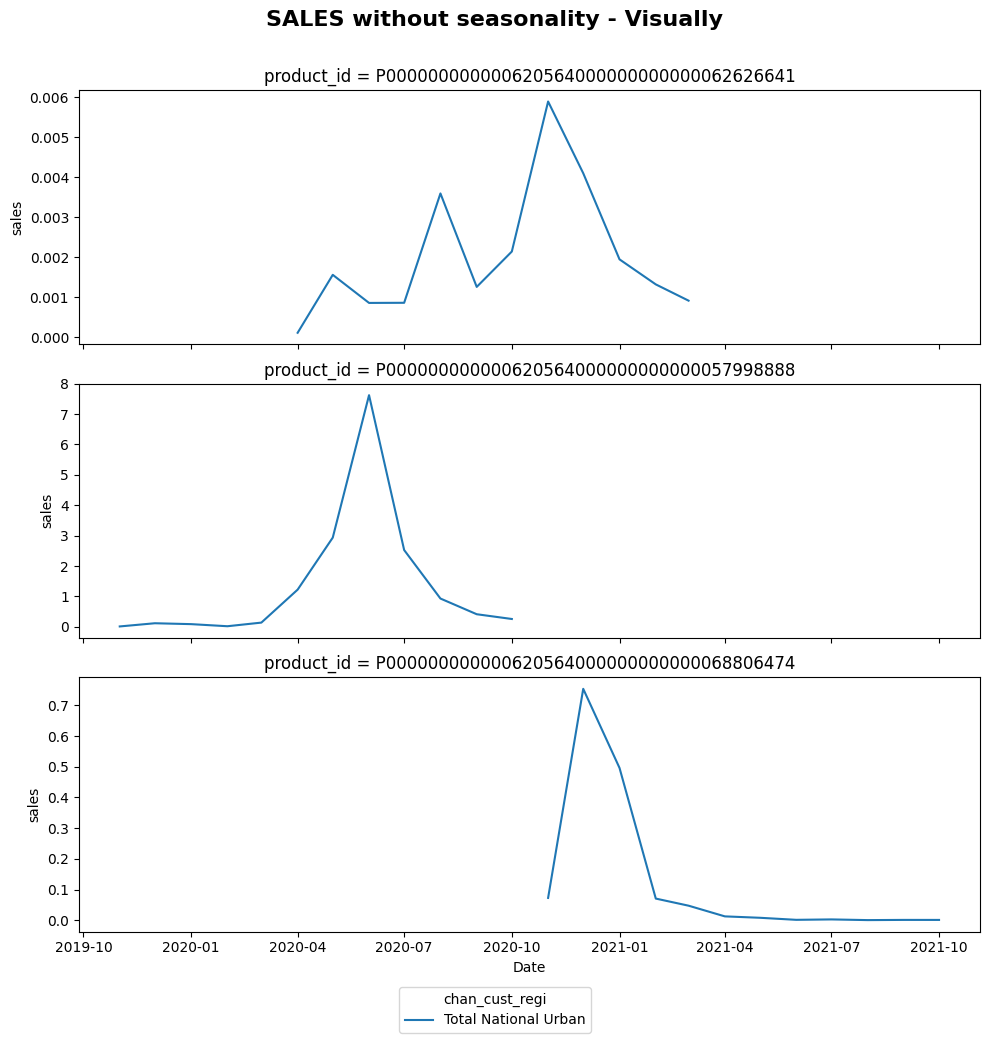

In [42]:
actuals_deflated_plot = actuals_deflated[:]
actuals_deflated_plot = actuals_deflated_plot[actuals_deflated_plot['product_id'].isin(new_product_sku['product_id'])]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

for i, product_id in enumerate(new_product_sku['product_id']):
    actuals_deflated_plot_id = actuals_deflated_plot[actuals_deflated_plot['product_id'] == product_id]
    sns.lineplot(x=actuals_deflated_plot_id['date'], 
                 y=actuals_deflated_plot_id['sales'], 
                 hue=actuals_deflated_plot['chan_cust_regi'],
                 ax=axes[i])
    axes[i].set_title(f"product_id = {product_id}")
axes[2].set_xlabel('Date')
# Adjust the spacing between the subplots
plt.tight_layout()

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='outside lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05), title='chan_cust_regi')

# Remove the legends from the individual subplots
for ax in axes:
    ax.get_legend().remove()

# Show the plot
plt.subplots_adjust(top=0.9)
fig.suptitle('SALES without seasonality - Visually', fontsize=16, fontweight='bold')
plt.show()

### CHAN_CUST_REGI weight - all products
Please note that your original weighted WEI_DISTRIB (WD) will be multiplied by those percentages.

In [43]:
level_of_output_weight_df = level_of_output_weight[:]
level_of_output_weight_df.rename(columns={'level_of_output_weight_vs_total': 'TOTAL weight of this CHAN_CUST_REGI, %'}, inplace=True)
level_of_output_weight_df['TOTAL weight of this CHAN_CUST_REGI, %'] = round(level_of_output_weight_df['TOTAL weight of this CHAN_CUST_REGI, %'] * 100, 1)
level_of_output_weight_df[['chan_cust_regi', 'TOTAL weight of this CHAN_CUST_REGI, %']]

,chan_cust_regi,"TOTAL weight of this CHAN_CUST_REGI, %"
0,Total National Urban,100.0


It is done to avoid situation that e.g. 45% WD for Kiosks and 45% WD for Discounters will be treated equally

### Sample SKU aggregated to CHAN_CUST_REGI

In [44]:
# Prepare dict for renaming in explore steps
num_mean_renaming = {}

for key in num_mean_agg_dict.keys():
    num_mean_renaming[key] = 'mean_' + feature_names[str(key)[:10]]
    
num_mean_2_renaming = {}

for key in num_mean_agg_2_dict.keys():
    num_mean_2_renaming[key] = 'mean_' + feature_names[str(key)[:10]]

segmentation_prep_df = segmentation_prep[:]
segmentation_prep_df.rename(columns={'new_level_of_output_weight': 'TOTAL weight of this CHAN_CUST_REGI, %',
                                     'sum_sales_feature':'sum_sales',
                                     'mean_wei_distrib_1_4m':'mean_wei_distrib_1_4m, %',
                                     'mean_wei_distrib_5_8m':'mean_wei_distrib_5_8m, %',
                                     'mean_wei_distrib_9_12m':'mean_wei_distrib_9_12m, %',
                                    **num_mean_renaming}, inplace=True)

segmentation_prep_df['TOTAL weight of this CHAN_CUST_REGI, %'] = round(segmentation_prep_df['TOTAL weight of this CHAN_CUST_REGI, %'] * 100, 2)
segmentation_prep_df['sum_sales'] = round(segmentation_prep_df['sum_sales'], 2)
segmentation_prep_df['mean_price'] = round(segmentation_prep_df['mean_price'], 2)
segmentation_prep_df['mean_wei_distrib_1_4m, %'] = round(segmentation_prep_df['mean_wei_distrib_1_4m, %'] * 100, 2)
segmentation_prep_df['mean_wei_distrib_5_8m, %'] = round(segmentation_prep_df['mean_wei_distrib_5_8m, %'] * 100, 2)
segmentation_prep_df['mean_wei_distrib_9_12m, %'] = round(segmentation_prep_df['mean_wei_distrib_9_12m, %'] * 100, 2)

segmentation_prep_df = segmentation_prep_df[segmentation_prep_df['product_id'].isin(new_product_sku['product_id'])]

segmentation_prep_df

,product_id,chan_cust_regi,sum_sales,mean_price,mean_NUM_FEAT_1_NAME,"mean_wei_distrib_1_4m, %","mean_wei_distrib_5_8m, %","mean_wei_distrib_9_12m, %","TOTAL weight of this CHAN_CUST_REGI, %"
348,P000000000000620564000000000000057998888,Total National Urban,16.30,637.47,3.0,0.10,3.74,3.30,100.0
603,P000000000000620564000000000000062626641,Total National Urban,0.02,2442.10,1.0,0.01,0.01,0.01,100.0
803,P000000000000620564000000000000068806474,Total National Urban,1.47,668.09,2.0,1.86,0.05,0.01,100.0


### Sample SKU aggregated to be used in forecasting

In [45]:
cat_names = {key: value for key, value in feature_names.items() if key.startswith('cat')}
segmentation_prep_sku_df = segmentation_prep_sku.drop('sum_sales_feature', axis=1)
segmentation_prep_sku_df = segmentation_prep_sku_df[segmentation_prep_sku_df['product_id'].isin(new_product_sku['product_id'])]

segmentation_prep_sku_df.rename(columns={'sum_sales_feature':'sum_sales',
                                         'mean_wei_distrib_1_4m':'mean_wei_distrib_1_4m, %',
                                         'mean_wei_distrib_5_8m':'mean_wei_distrib_5_8m, %',
                                         'mean_wei_distrib_9_12m':'mean_wei_distrib_9_12m, %',
                                         **num_mean_2_renaming,
                                         **cat_names}, inplace=True)

segmentation_prep_sku_df['mean_price'] = round(segmentation_prep_sku_df['mean_price'], 2)
segmentation_prep_sku_df['mean_wei_distrib_1_4m, %'] = round(segmentation_prep_sku_df['mean_wei_distrib_1_4m, %'] * 100, 2)
segmentation_prep_sku_df['mean_wei_distrib_5_8m, %'] = round(segmentation_prep_sku_df['mean_wei_distrib_5_8m, %'] * 100, 2)
segmentation_prep_sku_df['mean_wei_distrib_9_12m, %'] = round(segmentation_prep_sku_df['mean_wei_distrib_9_12m, %'] * 100, 2)

segmentation_prep_sku_df

,product_id,mean_price,"mean_wei_distrib_1_4m, %","mean_wei_distrib_5_8m, %","mean_wei_distrib_9_12m, %",mean_NUM_FEAT_1_NAME,CAT_FEAT_1_NAME
348,P000000000000620564000000000000057998888,637.47,0.10,3.74,3.30,3.0,C
603,P000000000000620564000000000000062626641,2442.10,0.01,0.01,0.01,1.0,A
803,P000000000000620564000000000000068806474,668.09,1.86,0.05,0.01,2.0,B


Those numbers will be used in comparison of your launch assumptions with historical launches.
NOTE! Weighted WEI_DISTRIB was multiplied by its weight in total.

### Aggregated statistics - all products

In [46]:
segmentation_prep_sku_total = segmentation_prep_sku.drop(['product_id', 'sum_sales_feature'] + cat_features, axis=1).agg(['min', 'max', 'mean']).reset_index(names='Measure')
segmentation_prep_sku_total.insert(0, 'Records', len(segmentation_prep_sku))

segmentation_prep_sku_total.rename(columns={'mean_wei_distrib_1_4m':'mean_wei_distrib_1_4m, %',
                                            'mean_wei_distrib_5_8m':'mean_wei_distrib_5_8m, %',
                                            'mean_wei_distrib_9_12m':'mean_wei_distrib_9_12m, %',
                                            **num_mean_2_renaming}, inplace=True)

segmentation_prep_sku_total['mean_price'] = round(segmentation_prep_sku_total['mean_price'], 2)
segmentation_prep_sku_total['mean_wei_distrib_1_4m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_1_4m, %'] * 100, 2)
segmentation_prep_sku_total['mean_wei_distrib_5_8m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_5_8m, %'] * 100, 2)
segmentation_prep_sku_total['mean_wei_distrib_9_12m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_9_12m, %'] * 100, 2)

segmentation_prep_sku_total

,Records,Measure,mean_price,"mean_wei_distrib_1_4m, %","mean_wei_distrib_5_8m, %","mean_wei_distrib_9_12m, %",mean_NUM_FEAT_1_NAME
0,921,min,209.53,0.00,0.00,0.00,1.000000
1,921,max,9014.78,51.08,82.72,89.57,4.000000
2,921,mean,1652.66,3.51,4.41,4.30,2.486428


The tool will be more precise if assumptions of your new launch are in min-max range of historical launches.

### All new products SKUs

In [47]:
# Table with all new launches
actuals_filtered_total = actuals_filtered[:].drop_duplicates(subset='product_id')
actuals_filtered_total = actuals_filtered_total.merge(product_description_output, on='product_id')
actuals_filtered_total = actuals_filtered_total[['product_id', 'product_name', 'chan_cust_regi', 'level_of_output_launch_date']]

# Set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

actuals_filtered_total

,product_id,product_name,chan_cust_regi,level_of_output_launch_date
0,P000000000000620564000000000000044880516,CHOKODELIKA EXCL. WCH CURRNT&RSPBRRY&STRWBRRY ...,Total National Urban,2019-10-01
1,P000000000000620564000000000000054328210,AKKOND KOF.S MOL. MCH COFFEE TB 0.09KG E,Total National Urban,2019-06-01
2,P000000000000620564000000000000052033940,AKKOND TYOMNIY 52%BCH TB 0.09KG E,Total National Urban,2019-04-01
3,P000000000000620564000000000000058019686,MAKKONDO MOLOCHNIY MCH CRISPY-CRML TB 0.09KG E,Total National Urban,2019-12-01
4,P000000000000620564000000000000058019419,MAKKONDO MOLOCHNIY MCH HAZLN TB 0.09KG E,Total National Urban,2019-11-01
5,P000000000000620564000000000000062536083,MAKKONDO MOLOCHNIY MCH WHOL-HZLNT TB 0.09KG E,Total National Urban,2020-05-01
6,P000000000000620564000000000000068179483,SHOKO-KROKO MCH TB 0.02KG E,Total National Urban,2020-12-01
7,P000000000000620564000000000000068179343,SHOKO-KROKO MCH CERL&MLK TB 0.023KG E,Total National Urban,2020-11-01
8,P000000000000620564000000000000052157119,RITTER SPORT EXTRA COCOA S NAS.VK.IZ PERU 74%B...,Total National Urban,2019-03-01
9,P000000000000620564000000000000057912072,RITTER SPORT EXTRA COCOA S NAS.VK.IZ PERU 74%B...,Total National Urban,2019-10-01


In [48]:
# Reset the display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

## Export NPF_EXPLORE_OUTPUT.xlsx
Path the same as input dataset

You can then load it into PowerBI NPF 2.0 Dashboard to better understand the market context, review some specific SKU or make own forecast. Own Forecast functionality should be treated as a optional addition to Statistical Forecast

In [49]:
# write to excel file - path the same as input dataset
path_to_file = input_dataset_path.rsplit('\\', 1)[0]

writer = pd.ExcelWriter(path_to_file + f'\\{assumptions.index[0]}_NPF_EXPLORE_OUTPUT.xlsx', engine="xlsxwriter")

actuals_filtered_output['date'] = actuals_filtered_output['date'].dt.date
actuals_filtered_output.to_excel(
    writer, sheet_name='ACTUALS_FILTR', index=False)

segmentation_prep_sku_output['min_launch_date'] = segmentation_prep_sku_output['min_launch_date'].dt.date
segmentation_prep_sku_output.to_excel(
    writer, sheet_name='AGG_NEW_LAUNCHES', index=False)

seasonal_effect_prep.to_excel(writer, sheet_name='SEASONALITY', index=False)

actuals_deflated_output['date'] = actuals_deflated_output['date'].dt.date
actuals_deflated_output['min_launch_date'] = actuals_deflated_output['min_launch_date'].dt.date
actuals_deflated_output['level_of_output_launch_date'] = actuals_deflated_output['level_of_output_launch_date'].dt.date
actuals_deflated_output.to_excel(
    writer, sheet_name='ACTUALS_DEFL', index=False)

segmentation_prep_per_ch_output['min_launch_date'] = segmentation_prep_per_ch_output['min_launch_date'].dt.date
segmentation_prep_per_ch_output.to_excel(
    writer, sheet_name='AGG_NEW_LAUNCHES_PER_CH', index=False)

forecast_rows_output = forecast_rows.copy()
forecast_rows_output['date'] = forecast_rows_output['date'].dt.date
forecast_rows_output.to_excel(writer, sheet_name='FORECAST_DATE_DETAILS', index=False)

writer.close()

# EXPLORE FORECAST

## Prepare to explore

### Find k nearest neighbors function

In [50]:
def find_k_neighbors(
    input_data: pd.DataFrame,
    assumptions: pd.DataFrame,
    features_weights: dict,
    k: int,
    find_best_k: bool = False,
) -> pd.DataFrame:
    """
    Find k nearest neighbours to the assumption data.

    Objects passed to the function are DataFrame objects. Calculations are based on assumption features.
    Find best k by default 'automate', which will give the most nearest neigbours.

    Parameters
    ----------
    input_data : DataFrame
        dataset which will be used to compare assumption values with.
    assumptions : DataFrame
        dataset with products and features values to forecast.
    features_weights : dict
        the higher is a weight the closer to the specified value algorithm will want to be.
    k : int,
        Number of neighbors to find.
    find_best_k : bool, default False
        If true then best_k global variable will be generated.

    Returns
    -------
    DataFrame
        Dataset with k nearest products, feature values and distances
    """

    if len(default_num_features + num_features + cat_features) != len(assumptions.columns.tolist()) or len(my_feat_weights) != len(assumptions.columns.tolist()):
        raise ValueError(
            'Number of given features not alligned with number of assumptions features or weights')
    global best_k
    input_data = input_data.copy()
    assumptions = assumptions.copy()
    input_data = input_data[['product_id'] + assumptions.columns.tolist()]
    input_checked = input_data.drop_duplicates(subset=['product_id'])
    
    # Transform cat_features to binary type
    for cat_feature in cat_features:
        input_checked[cat_feature] = input_checked[cat_feature].apply(lambda x: 1 if x == assum_cat_features[cat_feature] else 0)
    for cat_feature in cat_features:
        assumptions[cat_feature] = 1
    
    scaler = MinMaxScaler()
    # Fit only on input_checked
    scaler.fit(input_checked[default_num_features + num_features])

    # Scale both input_checked and assumptions
    input_checked[default_num_features + num_features] = scaler.transform(
        input_checked[default_num_features + num_features])

    assumptions[default_num_features + num_features] = scaler.transform(
        assumptions[default_num_features + num_features])

    # applying weights to input
    for column in assumptions.columns.tolist():
        input_checked[column] = input_checked[column] * features_weights[column]

    # applying weights to assumptions
    for column in assumptions.columns.tolist():
        assumptions[column] = assumptions[column] * features_weights[column]

    # find k neighbors
    input_checked = input_checked.set_index('product_id')
    tree = KDTree(input_checked, metric='euclidean', leaf_size=2)
    dist, ind = tree.query(assumptions, k=15)
    neighbors = input_checked[:].reset_index().loc[ind.tolist()[0]]

    distances = pd.DataFrame(dist[0], index=ind[0], columns=['distance'])
    neighbors = pd.merge(neighbors, distances, left_index=True, right_index=True)
    neighbors['similarity'] = 1.0 / neighbors['distance']
    
    k_neighbors = neighbors.head(k).copy()
    k_neighbors['norm_distance'] = k_neighbors['distance'] / k_neighbors['distance'].sum()
    k_neighbors['norm_similarity'] = k_neighbors['similarity'] / k_neighbors['similarity'].sum()
    k_neighbors = k_neighbors.sort_values(by=['distance'])
    k_neighbors = k_neighbors.reset_index(drop=True)

    # find best k
    if find_best_k:
        k_neighbors['cum_dist'] = k_neighbors['norm_distance'].cumsum()
        for index, row in k_neighbors.iterrows():
            if row['cum_dist'] > row['norm_similarity']:
                best_k = index + 1
                break
    k_neighbors = k_neighbors.drop(columns=['norm_distance', 'distance', 'similarity'])
    return k_neighbors

### Forecast function based on k nearest neighbors

In [51]:
def forecast_using_knn_results(selected_product_neighbors: pd.DataFrame)-> list:
    """
    Forecast sales by applying median, mean and weighted knn to sales of nearest neighbors
    Parameters
    ----------
    selected_product_neighbors : DataFrame
        dataset of nearest neighbors and their sales.
    Returns
    -------
    3 DataFrames
        prediction - prediction by chan_cust_regi
        prediciton_overall - general prediction without grouping by chan_cust_regi
        actuals_to_forecast - for plotting neighbors sales
    """
    ap = actuals_prep.copy()
    ap = ap.drop_duplicates(subset='product_id')
    sps = segmentation_prep_sku.copy()
    sps = sps.rename(columns={**num_mean_3_renaming})
    selected_product_neighbors = selected_product_neighbors.copy()

    selected_product_neighbors = selected_product_neighbors.merge(ap[[
        'product_id', 'product_name', 'manufacturer'] + cat_features], on='product_id')

    selected_product_neighbors = selected_product_neighbors.merge(sps[['product_id'] + num_features], on='product_id')

    # Reordeting columns
    selected_product_neighbors = selected_product_neighbors.reindex(
        columns=['product_id', 'product_name', 'manufacturer'] + default_num_features + num_features + cat_features + ['norm_similarity'])

    selected_product_neighbors = selected_product_neighbors.sort_values('norm_similarity', ascending=False)

    """
    Select data from actuals_prep for selected neighbours,
    because prepared data consists of level of output which has at least 12m of history.
    For prediction we want to use other level of output, which don`t have 12m of history, as well

    For example product A was launche in peetrol stations for first 5 months and then
    it disappeared from petrol stations and was sold only in hypermarkets for 12m+.
    We have in our current dataset only hypermarket data for product A.
    BUT! for prediction of a new launch we also want to use data for petrol stations,
    because it will affect the prediction and give more comprehensive forecast
    """

    test_level_of_output_df = actuals_prep[[
        'product_id', 'chan_cust_regi', 'date']].copy()

    test_level_of_output_df['level_of_output_launch_date'] = test_level_of_output_df.groupby(
        ['product_id', 'chan_cust_regi'])['date'].transform('min')

    test_level_of_output_df['number_of_records'] = test_level_of_output_df.groupby(
        ['product_id', 'chan_cust_regi'])['product_id'].transform('count')

    # pick products from new_product_filter_prep and choose 12 months from level_of_output_launch_date
    test_level_of_output_df = test_level_of_output_df.loc[test_level_of_output_df['date'] <=
                                                          test_level_of_output_df['level_of_output_launch_date'] + pd.DateOffset(months=11 + 1)]

    test_level_of_output_df = test_level_of_output_df[['product_id', 'chan_cust_regi', 'level_of_output_launch_date', 'number_of_records']].drop_duplicates().reset_index(drop=True)

    actuals_to_forecast = actuals_deflated[['product_id', 'chan_cust_regi', 'date', 'relative_month', 'sales']].copy()
    actuals_to_forecast = actuals_to_forecast.merge(selected_product_neighbors[['product_id', 'norm_similarity']],
                                                                              on='product_id')
    actuals_prep_more_info = actuals_prep.copy()
    actuals_prep_more_info = actuals_prep_more_info.drop_duplicates()
    actuals_prep_more_info = actuals_prep_more_info.merge(test_level_of_output_df[['product_id', 'chan_cust_regi', 'level_of_output_launch_date', 'number_of_records']],
                                                          on=['product_id', 'chan_cust_regi'])

    actuals_prep_more_info['relative_month'] = actuals_prep_more_info.apply(lambda row: len(
        pd.period_range(start=row['level_of_output_launch_date'], end=row['date'], freq='M')), axis=1)

    actuals_prep_more_info = actuals_prep_more_info[actuals_prep_more_info['number_of_records'] >= 6]
    actuals_prep_more_info = actuals_prep_more_info.drop('number_of_records', axis=1).reset_index(drop=True)

    """
    Adding to forecast those level_of_outputs which has less than 12 months of history 
    but more than 6 months
    """
    atf = actuals_to_forecast.copy().drop_duplicates(
        subset=['product_id', 'chan_cust_regi'])
    actuals_to_forecast_less_history = actuals_prep_more_info[[
        'product_id', 'chan_cust_regi', 'date', 'sales', 'relative_month']].copy()
    actuals_to_forecast_less_history = actuals_to_forecast_less_history.merge(selected_product_neighbors[['product_id', 'norm_similarity']],
                                                                              on='product_id')

    actuals_to_forecast_less_history['month'] = actuals_to_forecast_less_history['date'].dt.month
    actuals_to_forecast_less_history = actuals_to_forecast_less_history.merge(seasonal_effect_prep[['month', 'seasonal_component']],
                                                                              on='month')

    actuals_to_forecast_less_history['sales'] = actuals_to_forecast_less_history['sales'] / \
        actuals_to_forecast_less_history['seasonal_component']

    actuals_to_forecast_less_history = actuals_to_forecast_less_history.merge(atf[['product_id', 'chan_cust_regi', 'norm_similarity']], on=[
                                                                              'product_id', 'chan_cust_regi'], how='left', suffixes=('', '_merged'))

    actuals_to_forecast_less_history = actuals_to_forecast_less_history[(
        actuals_to_forecast_less_history['norm_similarity_merged'].isna()) & (actuals_to_forecast_less_history['relative_month'] <= 12)]

    actuals_to_forecast_less_history = actuals_to_forecast_less_history[list(actuals_to_forecast.columns)]

    actuals_to_forecast = pd.concat([actuals_to_forecast, actuals_to_forecast_less_history])

    # Prediction using selected neighbors on level of output
    prediction = actuals_to_forecast.copy()

    prediction = prediction.merge(forecast_rows[[
                                  'relative_month', 'date']], on='relative_month', suffixes=('', '_forecast'))
    prediction['weighted_sales'] = prediction['sales'] * \
        prediction['norm_similarity']
    prediction = prediction.groupby(['date_forecast', 'chan_cust_regi']).agg(
        predicted_sales_feature_median_KNN=('sales', 'median'),
        predicted_sales_feature_average_KNN=('sales', 'mean'),
        predicted_sales_feature_weighted_KNN=('weighted_sales', 'sum')).reset_index()

    prediction['month'] = prediction['date_forecast'].dt.month
    prediction = prediction.merge(
        seasonal_effect_prep[['month', 'seasonal_component']], on='month')

    prediction[['predicted_sales_feature_median_KNN',
                'predicted_sales_feature_average_KNN',
                'predicted_sales_feature_weighted_KNN']] = \
        prediction[['predicted_sales_feature_median_KNN',
                    'predicted_sales_feature_average_KNN',
                    'predicted_sales_feature_weighted_KNN']].apply(lambda x: x * prediction['seasonal_component'])

    prediction = prediction.iloc[:, :-2]

    # Prediction using selected neighbors on overall level (month-by-month)

    prediction_overall = prediction.copy()
    prediction_overall = prediction_overall.groupby('date_forecast').agg(
        predicted_sales_feature_median_KNN=('predicted_sales_feature_median_KNN', 'sum'),
        predicted_sales_feature_average_KNN=('predicted_sales_feature_average_KNN', 'sum'),
        predicted_sales_feature_weighted_KNN=('predicted_sales_feature_weighted_KNN', 'sum')).reset_index()

    return prediction, prediction_overall, actuals_to_forecast

### Forecast plotting function

In [52]:
def plot_forecast(selected_product_neighbors: pd.DataFrame) -> None:
    """
    Function shows plots of forecast by chai_cust_regi and overall forecast, 
    based on forecasts of function "forecast_using_knn_results".
    ----------
    selected_product_neighbors : DataFrame
        dataset of nearest neighbors and their sales.
    Returns
    -------
    None
        Just plotting forecasts
    """
    df_to_plot_prediction = forecast_using_knn_results(selected_product_neighbors)[1]

    fig_prediction, ax = plt.subplots(figsize=(10, 5))
    for col in df_to_plot_prediction.columns[1:]:
        ax.plot(df_to_plot_prediction['date_forecast'], df_to_plot_prediction[col], label=col, linestyle='--')

    # Customize the plot
    ax.set(xlabel="date",
           ylabel="sales")

    ax.legend()
    fig_prediction.suptitle('Overall SALES - Forecast', fontsize=16, fontweight='bold')
    plt.show()

    df_to_plot_prediction_overall = forecast_using_knn_results(selected_product_neighbors)[0]

    chan_cust_regi_number = len(forecast_using_knn_results(
        selected_product_neighbors)[0]['chan_cust_regi'].unique())
    fig, axes = plt.subplots(nrows=chan_cust_regi_number,
                             ncols=1,
                             figsize=(10, 5))

    for i, chan_cust_regi in enumerate(forecast_using_knn_results(selected_product_neighbors)[0]['chan_cust_regi'].unique()):
        df_to_plot = df_to_plot_prediction_overall[df_to_plot_prediction_overall['chan_cust_regi'] == chan_cust_regi]
        for col in df_to_plot.columns[2:]:
            axes.plot(df_to_plot['date_forecast'], df_to_plot[col], label=col, linestyle='--')
        if chan_cust_regi_number != 1:
            axes[i].set_title(f"chan_cust_regi = {chan_cust_regi}")
        else:
            axes.set_title(f"chan_cust_regi = {chan_cust_regi}")



    # Customize the plot
    axes.set(xlabel="date",
           ylabel="sales")

    axes.legend()
    fig.suptitle('SALES by chan_cust_regi - Forecast', fontsize=16, fontweight='bold')
    plt.show()

### Plot neighbors sales function

In [53]:
def plot_neighbors(selected_product_neighbors: pd.DataFrame) -> None:
    """
    Function shows plots of sales by chai_cust_regi and overall sales of nearest neighbors, 
    based on forecasts of function "forecast_using_knn_results".
    ----------
    selected_product_neighbors : DataFrame
        dataset of nearest neighbors and their sales.
    Returns
    -------
    None
        Just plotting neighbors sales
    """
    neighbors_overall = forecast_using_knn_results(selected_product_neighbors)[2].copy()

    k = len(neighbors_overall['product_id'].unique())

    if k > 1:
        cols_number = 3 if k % 2 == 1 else 2
        rows_number = k // cols_number + 1 if k % cols_number != 0 else k // cols_number
    elif k == 2:
        cols_number, rows_number = 2, 1
    elif k == 1:
        cols_number, rows_number = 1, 1

    fig, axes = plt.subplots(nrows=rows_number,
                             ncols=cols_number,
                             sharex=True,
                             sharey=True,
                             figsize=(10 * cols_number, 5 * rows_number))

    for i, product_id in enumerate(neighbors_overall['product_id'].unique()):
        if k == 2 or k == 1:
            row = 0
            col = i
            selected_product_to_plot = neighbors_overall[neighbors_overall['product_id'] == product_id]
            axes[col].plot(selected_product_to_plot['relative_month'],
                                selected_product_to_plot['sales'])

            axes[col].set_title(f'Product ID: {product_id}')
        else:
            row = i // cols_number
            col = i % cols_number
            selected_product_to_plot = neighbors_overall[neighbors_overall['product_id'] == product_id]
            axes[row, col].plot(selected_product_to_plot['relative_month'],
                                selected_product_to_plot['sales'])

            axes[row, col].set_title(f'Product ID: {product_id}')

    fig.suptitle('Overall SALES - Neighbors',
                 fontsize=16, fontweight='bold')

    fig.text(0.5, 0.04, 'relative month', ha='center', fontsize=15)
    fig.text(0.11, 0.5, 'Sales', va='center', rotation='vertical', fontsize=15)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

    # Plot neighbors sales by chai_cust_regi

    fig, axes = plt.subplots(nrows=rows_number,
                             ncols=cols_number,
                             sharex=True,
                             sharey=True,
                             figsize=(10 * cols_number, 5 * rows_number))
    

    for i, product_id in enumerate(neighbors_overall['product_id'].unique()):
        if k == 2 or k==1:
            row = 0
            col = i
            
            selected_product_to_plot = neighbors_overall[neighbors_overall['product_id'] == product_id]

            sns.lineplot(x=selected_product_to_plot['relative_month'], 
                         y=selected_product_to_plot['sales'], 
                         hue=selected_product_to_plot['chan_cust_regi'],
                         ax=axes[col])

            axes[col].set_title(f'product_id = {product_id}')
            axes[col].set(xlabel=None)
            axes[col].set(ylabel=None)

            
        else:
            row = i // cols_number
            col = i % cols_number

            selected_product_to_plot = neighbors_overall[neighbors_overall['product_id'] == product_id]

            sns.lineplot(x=selected_product_to_plot['relative_month'], 
                         y=selected_product_to_plot['sales'], 
                         hue=selected_product_to_plot['chan_cust_regi'],
                         ax=axes[row, col])

            axes[row, col].set_title(f'product_id = {product_id}')
            axes[row, col].set(xlabel=None)
            axes[row, col].set(ylabel=None)


    fig.suptitle('SALES by CHAN_CUST_REGI - Neighbors', fontsize=16, fontweight='bold')

    # Create a single legend for the entire figure
    if k == 2 or k==1:
        handles, labels = axes[0].get_legend_handles_labels()
    else:
        handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='outside lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05), title='chan_cust_regi')

    # Remove the legends from the individual subplots
    for i, product_id in enumerate(neighbors_overall['product_id'].unique()):
        if k == 2 or k==1:
            row = 0
            col = i
            axes[col].get_legend().remove()
        else:
            row = i // cols_number
            col = i % cols_number
            
            axes[row, col].get_legend().remove()

    fig.text(0.5, 0.04, 'relative month', ha='center', fontsize=15)
    fig.text(0.11, 0.5, 'Sales', va='center', rotation='vertical', fontsize=15)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

### Display neighbors table function

In [54]:
def display_neighbors(selected_product_neighbors: pd.DataFrame) -> None:
    """
    Function display table of nearest neigbors
    ----------
    selected_product_neighbors : DataFrame
        dataset of nearest neighbors and their features.
    Returns
    -------
    DataFrame
        Dataset with k nearest products, feature values and norm_similarity
    """
    selected_product_neighbors = selected_product_neighbors[['product_id', 'norm_similarity']].copy()
    selected_product_neighbors = selected_product_neighbors.merge(product_description_output.iloc[:, :3],
                                                                 how='left',
                                                                 on='product_id')
    
    selected_product_neighbors = selected_product_neighbors.merge(segmentation_prep_sku.drop('sum_sales_feature', axis=1),
                                                                 how='left',
                                                                 on='product_id')
    
    # Move column "norm_similarity" to the last position
    column_to_move = selected_product_neighbors.pop('norm_similarity')
    selected_product_neighbors['norm_similarity'] = column_to_move
    selected_product_neighbors = selected_product_neighbors.rename(columns={
        **num_mean_2_renaming,
        **cat_names})
    display(selected_product_neighbors)

## Explore

### Parameters specified by You - Data

In [55]:
pd.DataFrame({'Selected dataset name': input_dataset_path.rsplit('\\', 1)[-1]}, index=[0])

,Selected dataset name
0,NPF3_INPUT_data_Template.xlsx


### Parameters specified by You - General

In [56]:
pd.DataFrame({'Dashboard type': 'Forecast',
              'Launch month': launch_month,
              'Selected features set': 'price wei_distrib ' + ' '.join(feature_names.values())}, index=[0])

,Dashboard type,Launch month,Selected features set
0,Forecast,2023-08-01,price wei_distrib NUM_FEAT_1_NAME CAT_FEAT_1_NAME


### Parameters specified by You - Forecast Assumptions

In [57]:
assumptions_df = assumptions.copy()
assumptions_df.insert(0, 'Number of similar','automatic' if number_of_similar == 0 else number_of_similar)
assumptions_df.insert(1, 'Categorical features importance', variables.loc['categorical features importance'].Value)
assumptions_df[list(assumptions_df.columns)[3:6]] = assumptions_df[list(assumptions_df.columns)[3:6]] * 100
assumptions_df = assumptions_df.rename(columns={**feature_names})

assumptions_df

,Number of similar,Categorical features importance,mean_price,mean_wei_distrib_1_4m,mean_wei_distrib_5_8m,mean_wei_distrib_9_12m,NUM_FEAT_1_NAME,CAT_FEAT_1_NAME
PRODUCT_ID,,,,,,,,
P000000000000620564000000000000052480393,automatic,Default (More like filtering),1176.993573,20.0,24.0,17.0,4,D


If you have more than one CHAN_CUST_REGI per SKU you should always remember to weight the DISTIRBUTION assumption properly.
To do this please use |Explore| dashboard and take a look on the table |CHAN_CUST_REGI weight - all products|.
If you are not sure, it is always a good choice to generate, separately, one forecast per CHAN_CUST_REGI

### Aggregated statistics - all products

# MINMAXSCALR + %

In [58]:
segmentation_prep_sku_total = segmentation_prep_sku.drop(['product_id', 'sum_sales_feature'], axis=1)
label_encoder = LabelEncoder()
for category_feature in cat_features:
    label_encoder.fit(segmentation_prep_sku_total[category_feature])
    segmentation_prep_sku_total[category_feature] = label_encoder.transform(segmentation_prep_sku_total[category_feature])

segmentation_prep_sku_total = segmentation_prep_sku_total.agg(['min', 'max', 'mean']).reset_index(names='Measure')
segmentation_prep_sku_total.insert(0, 'Records', len(segmentation_prep_sku))

segmentation_prep_sku_total.rename(columns={'mean_wei_distrib_1_4m':'mean_wei_distrib_1_4m, %',
                                            'mean_wei_distrib_5_8m':'mean_wei_distrib_5_8m, %',
                                            'mean_wei_distrib_9_12m':'mean_wei_distrib_9_12m, %',
                                            **num_mean_2_renaming,
                                            **cat_names}, inplace=True)

segmentation_prep_sku_total['mean_price'] = round(segmentation_prep_sku_total['mean_price'], 2)
segmentation_prep_sku_total['mean_wei_distrib_1_4m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_1_4m, %'] * 100, 2)
segmentation_prep_sku_total['mean_wei_distrib_5_8m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_5_8m, %'] * 100, 2)
segmentation_prep_sku_total['mean_wei_distrib_9_12m, %'] = round(segmentation_prep_sku_total['mean_wei_distrib_9_12m, %'] * 100, 2)

segmentation_prep_sku_total

,Records,Measure,mean_price,"mean_wei_distrib_1_4m, %","mean_wei_distrib_5_8m, %","mean_wei_distrib_9_12m, %",mean_NUM_FEAT_1_NAME,CAT_FEAT_1_NAME
0,921,min,209.53,0.00,0.00,0.00,1.000000,0.000000
1,921,max,9014.78,51.08,82.72,89.57,4.000000,3.000000
2,921,mean,1652.66,3.51,4.41,4.30,2.486428,1.486428


The tool will be more precise if assumptions of your new launch are in min-max range of historical launches.

### Results

,Number of neighbors - only most similar:,2
,Selected neighbors:,


,product_id,product_name,manufacturer,mean_price,mean_wei_distrib_1_4m,mean_wei_distrib_5_8m,mean_wei_distrib_9_12m,mean_NUM_FEAT_1_NAME,CAT_FEAT_1_NAME,norm_similarity
0,P000000000000620564000000000000052480393,RITTER SPORT BCH WHOL-HZLNT TB 2X0.01667KG NAB E,ALFRED RITTER/GERMANY,1176.993573,0.201075,0.237275,0.173625,4.0,D,0.963315
1,P000000000000620564000000000000057231537,NELLY(NELLI/SERBIA) NELINA PREM. MCH MILK&WFR ...,NELLI/SERBIA,717.621403,0.205025,0.254250,0.262000,4.0,D,0.036685


From the most to the least similar.


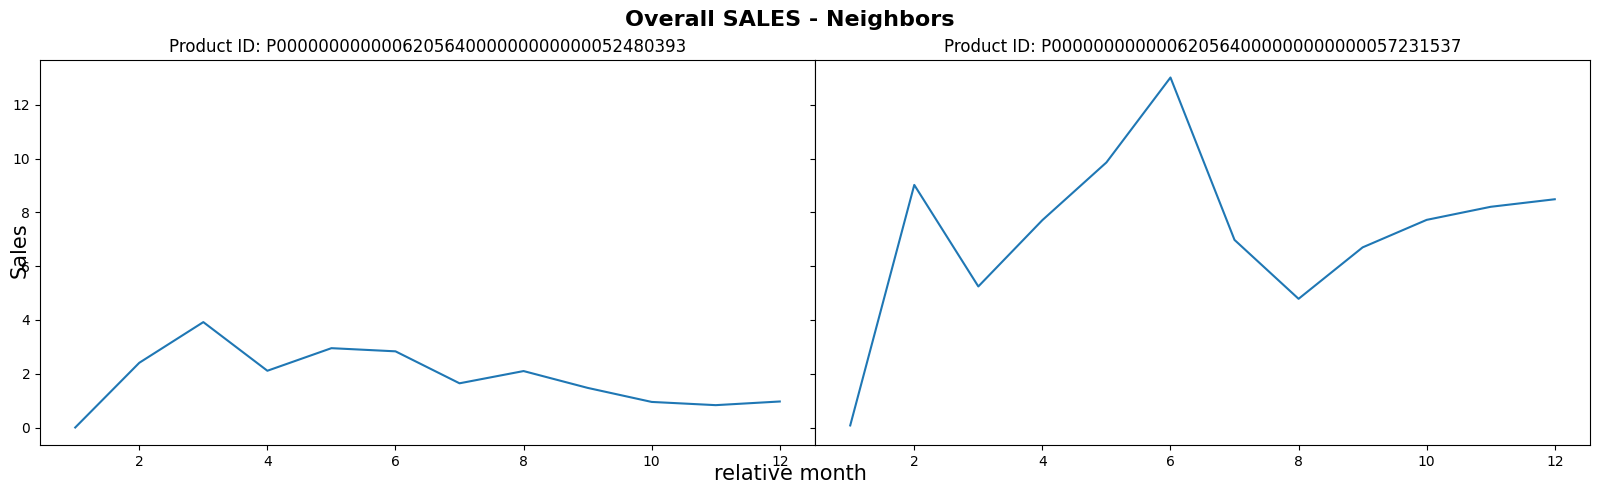

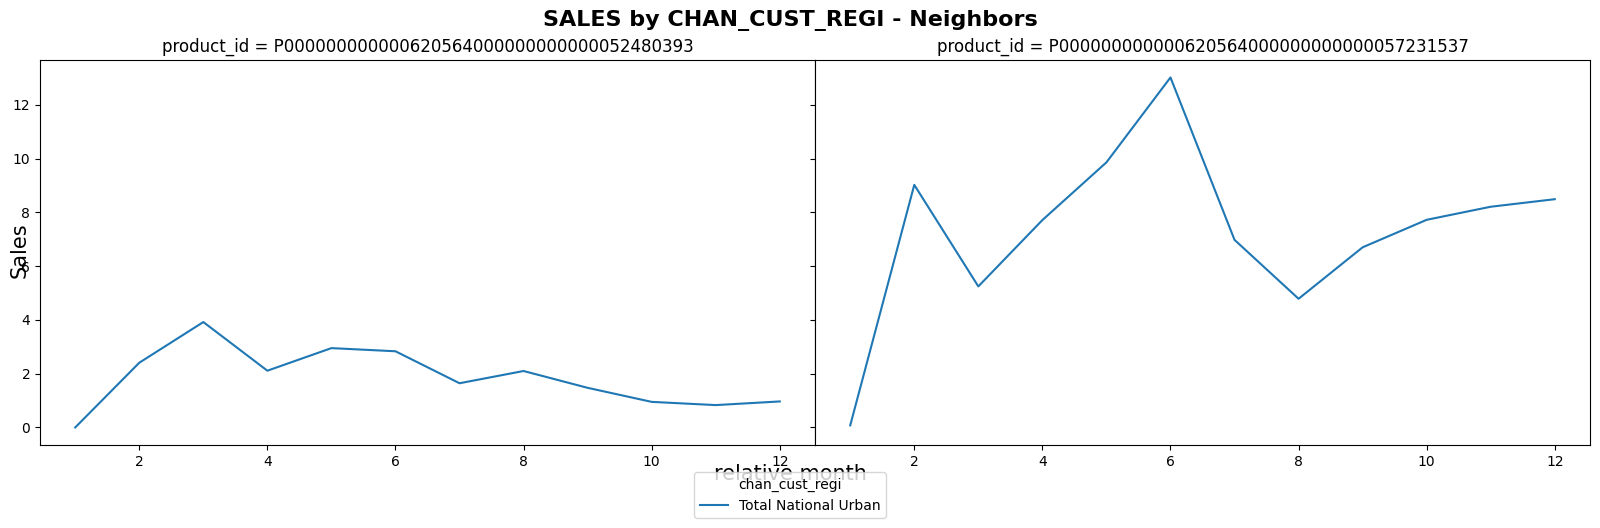

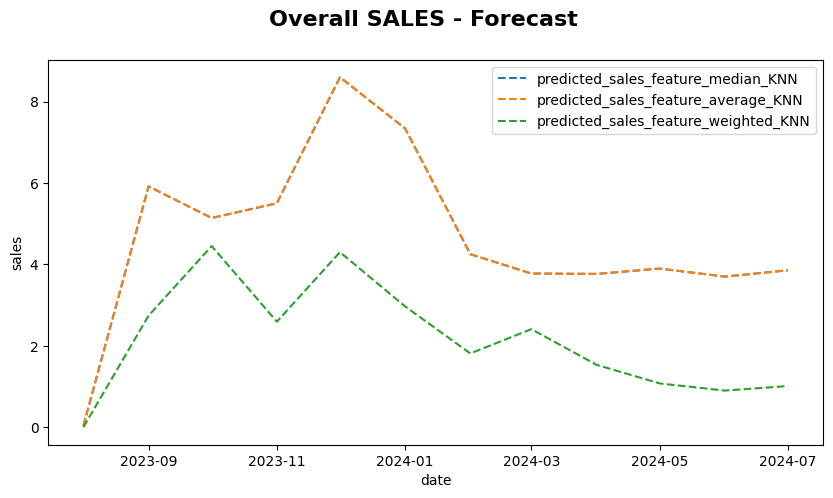

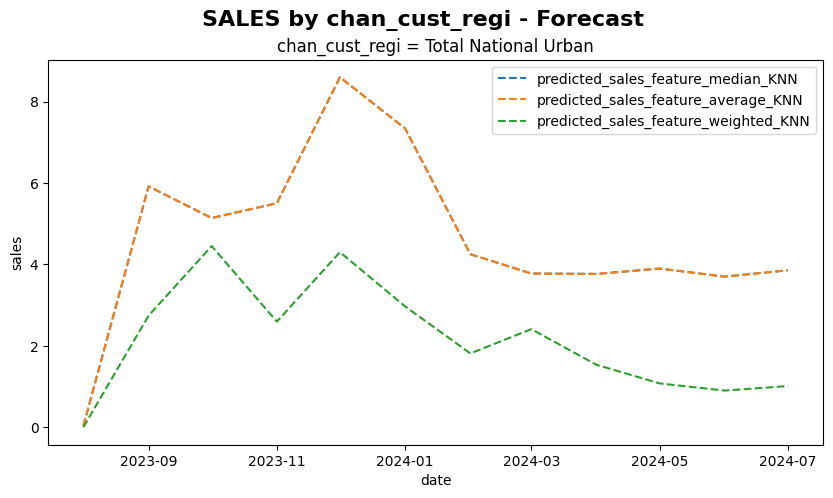

,Number of neighbors:,5
,Selected neighbors:,


,product_id,product_name,manufacturer,mean_price,mean_wei_distrib_1_4m,mean_wei_distrib_5_8m,mean_wei_distrib_9_12m,mean_NUM_FEAT_1_NAME,CAT_FEAT_1_NAME,norm_similarity
0,P000000000000620564000000000000052480393,RITTER SPORT BCH WHOL-HZLNT TB 2X0.01667KG NAB E,ALFRED RITTER/GERMANY,1176.993573,0.201075,0.237275,0.173625,4.0,D,0.893198
1,P000000000000620564000000000000057231537,NELLY(NELLI/SERBIA) NELINA PREM. MCH MILK&WFR ...,NELLI/SERBIA,717.621403,0.205025,0.254250,0.262000,4.0,D,0.034015
2,P000000000000620564000000000000065345425,RITTER SPORT MCH ROASTD-SLTD-CSHW TB 0.1KG E,ALFRED RITTER/GERMANY,952.261899,0.134350,0.170100,0.225000,4.0,D,0.029000
3,P000000000000620564000000000000055061237,RITTER SPORT MCH WAFER TB 0.1KG E,ALFRED RITTER/GERMANY,824.508663,0.157025,0.126050,0.049125,4.0,D,0.022326
4,P000000000000620564000000000000052157119,RITTER SPORT EXTRA COCOA S NAS.VK.IZ PERU 74%B...,ALFRED RITTER/GERMANY,920.748810,0.101725,0.242800,0.277575,4.0,D,0.021462


From the most to the least similar.


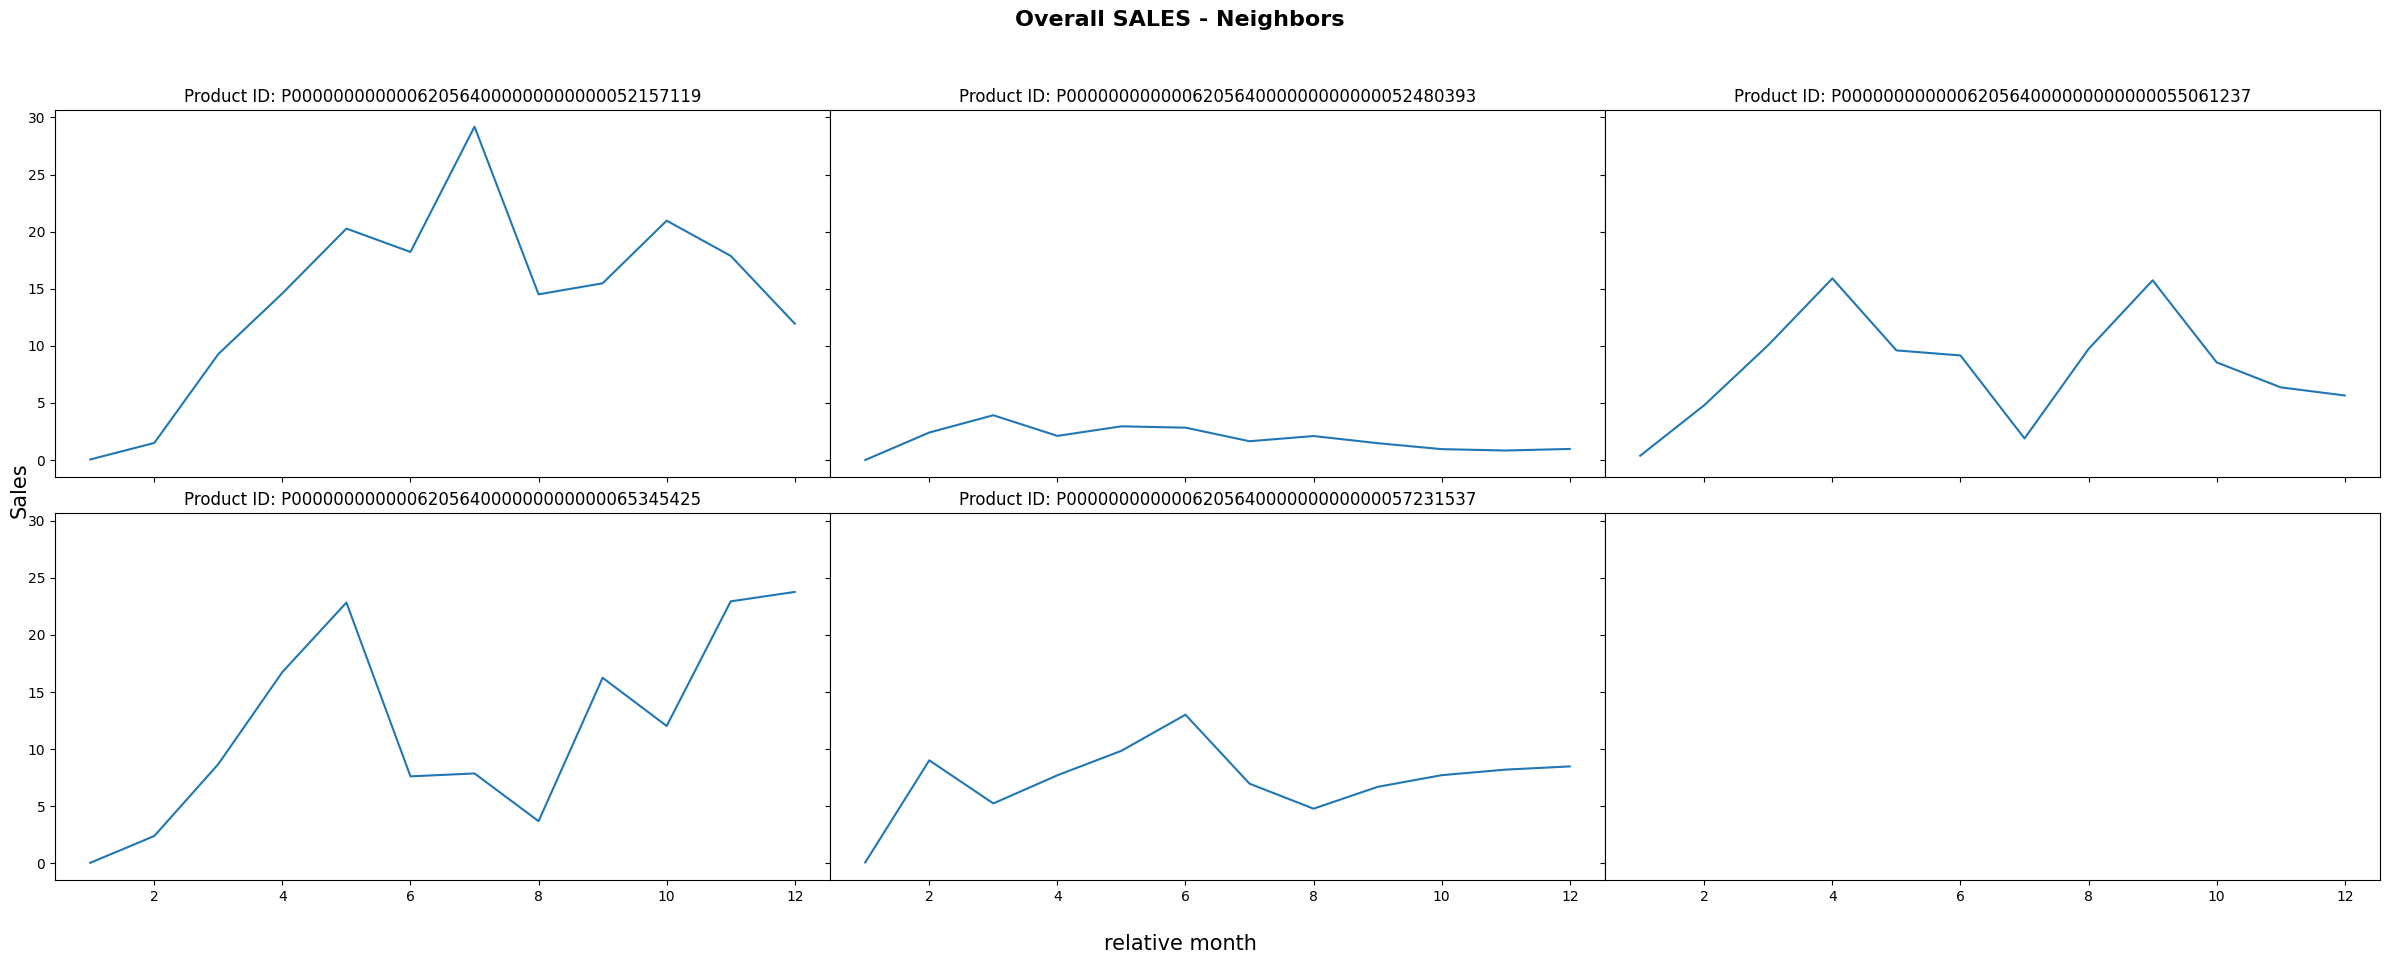

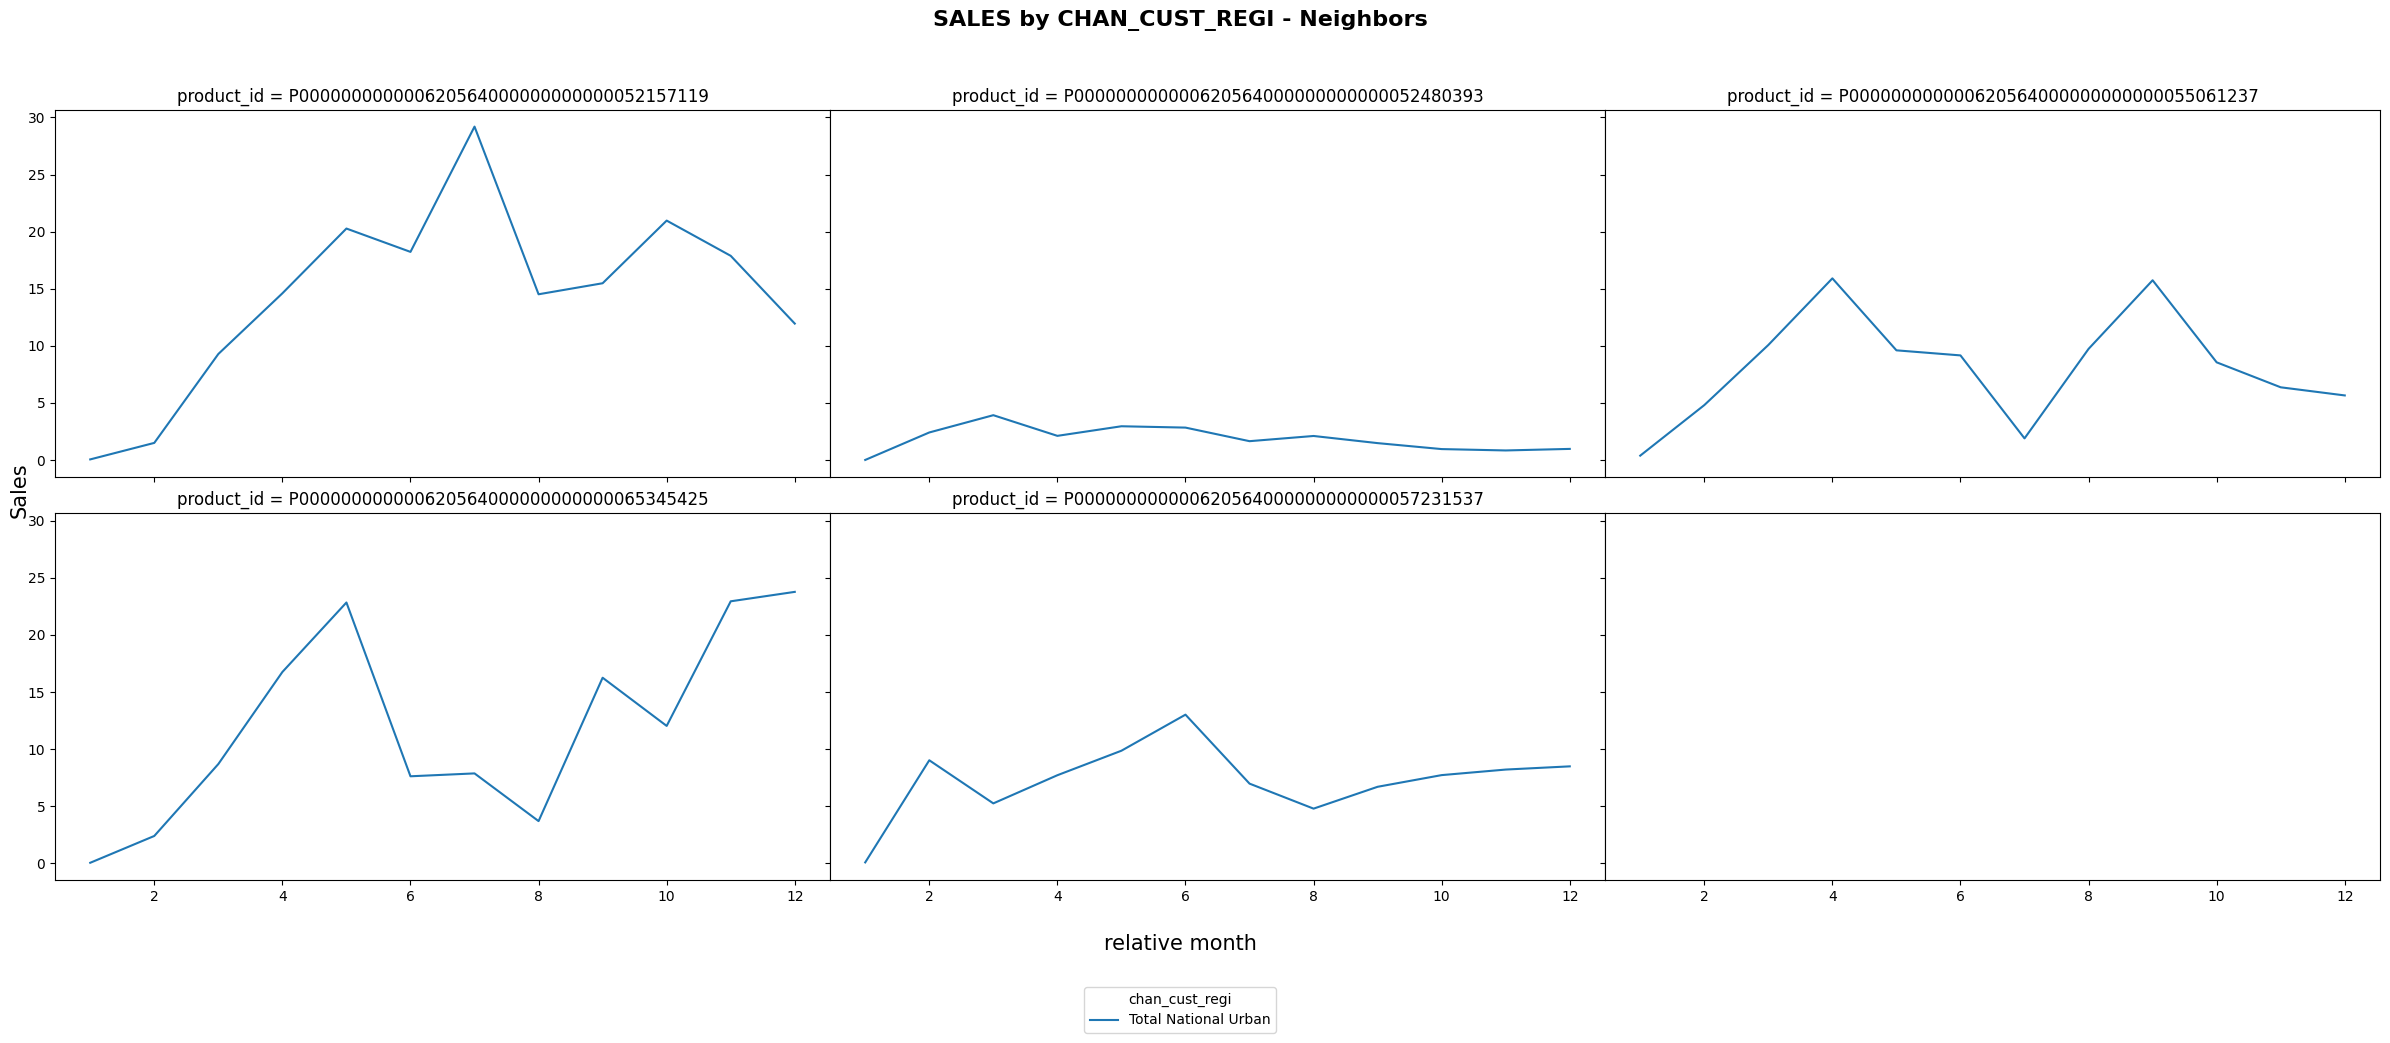

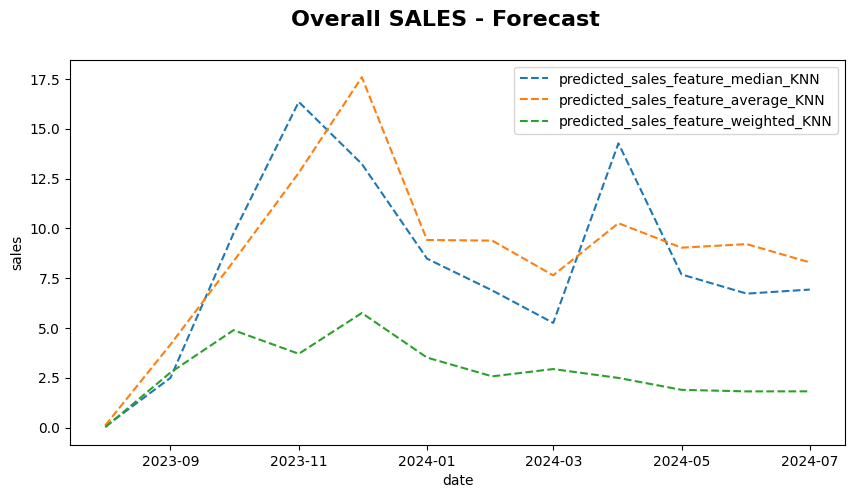

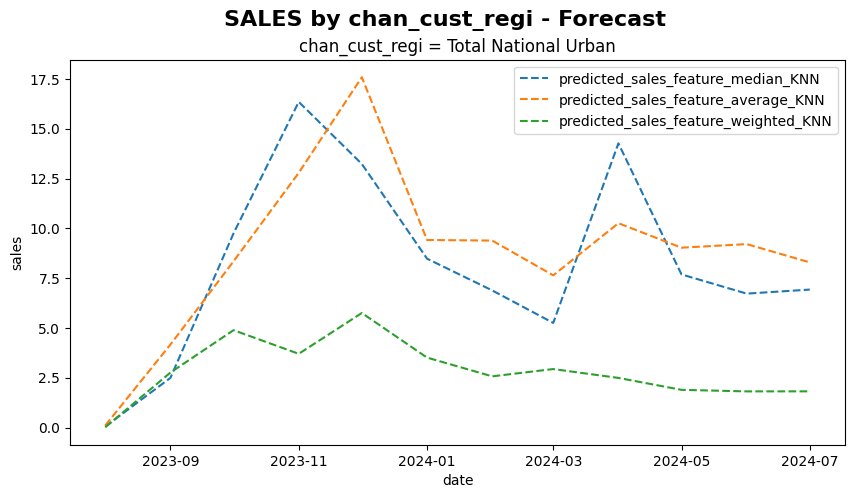

,Number of neighbors:,10
,Selected neighbors:,


,product_id,product_name,manufacturer,mean_price,mean_wei_distrib_1_4m,mean_wei_distrib_5_8m,mean_wei_distrib_9_12m,mean_NUM_FEAT_1_NAME,CAT_FEAT_1_NAME,norm_similarity
0,P000000000000620564000000000000052480393,RITTER SPORT BCH WHOL-HZLNT TB 2X0.01667KG NAB E,ALFRED RITTER/GERMANY,1176.993573,0.201075,0.237275,0.173625,4.0,D,0.822379
1,P000000000000620564000000000000057231537,NELLY(NELLI/SERBIA) NELINA PREM. MCH MILK&WFR ...,NELLI/SERBIA,717.621403,0.205025,0.254250,0.262000,4.0,D,0.031318
2,P000000000000620564000000000000065345425,RITTER SPORT MCH ROASTD-SLTD-CSHW TB 0.1KG E,ALFRED RITTER/GERMANY,952.261899,0.134350,0.170100,0.225000,4.0,D,0.026701
3,P000000000000620564000000000000055061237,RITTER SPORT MCH WAFER TB 0.1KG E,ALFRED RITTER/GERMANY,824.508663,0.157025,0.126050,0.049125,4.0,D,0.020556
4,P000000000000620564000000000000052157119,RITTER SPORT EXTRA COCOA S NAS.VK.IZ PERU 74%B...,ALFRED RITTER/GERMANY,920.748810,0.101725,0.242800,0.277575,4.0,D,0.019760
5,P000000000000620564000000000000066956833,ALPEN GOLD OREO BEL.I MOL. MXC BISCT-PCS&VNLL ...,MONDELEZ INTERNATIONAL,537.721540,0.276975,0.313900,0.272400,4.0,D,0.018172
6,P000000000000620564000000000000056744107,RSD ZOLOTAYA MARKA DUET V GOR 70%BCH TB 0.085KG E,NESTLE,645.160487,0.203425,0.344975,0.375550,4.0,D,0.016022
7,P000000000000620564000000000000069766725,TRAPA CORAZON MCH STRAWB. TB 0.09KG E,FABRICADO POR EUROPRALINE/SPAIN,688.143793,0.181200,0.057000,0.015600,4.0,D,0.015228
8,P000000000000620564000000000000059819760,RITTER SPORT WCH CRISPY-CHP&MNG&PSSN-FRT TB 0....,ALFRED RITTER/GERMANY,845.137061,0.312825,0.150250,0.019425,4.0,D,0.015053
9,P000000000000620564000000000000068178542,ALPEN GOLD DESERT BEZE PAVLOVA MCH MERNG&STRWB...,MONDELEZ INTERNATIONAL,700.281133,0.227000,0.270775,0.426000,4.0,D,0.014812


From the most to the least similar.


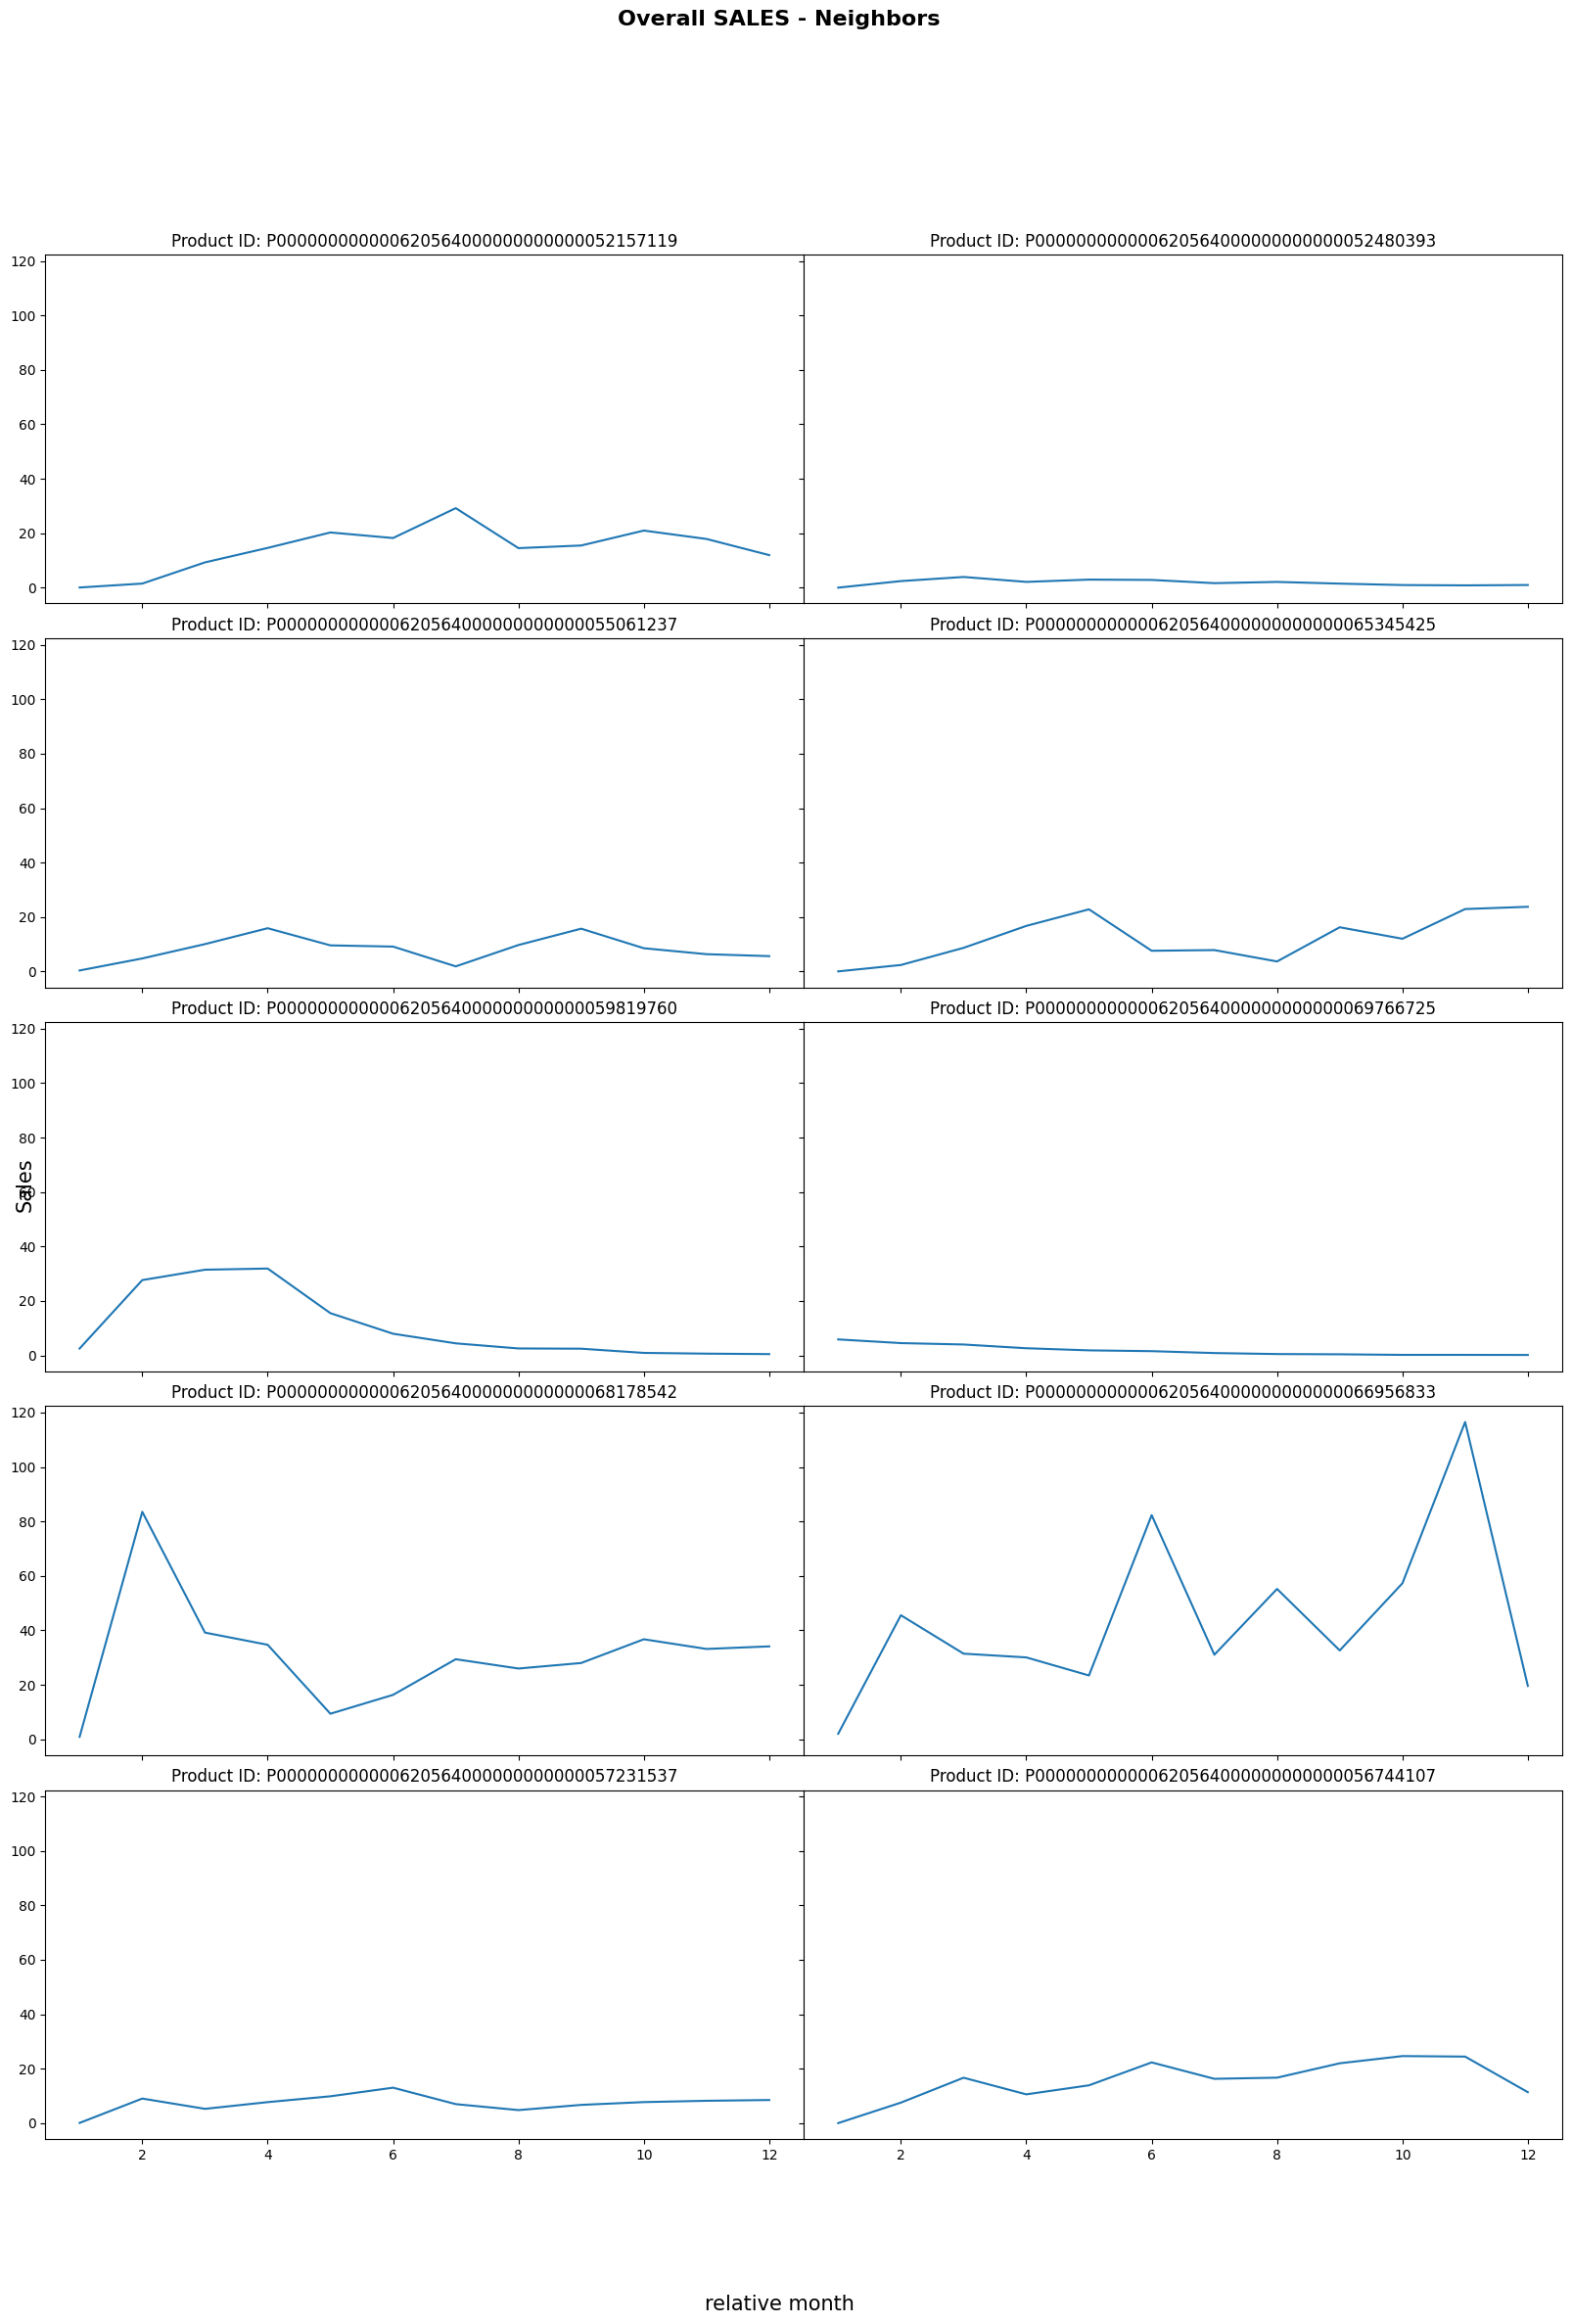

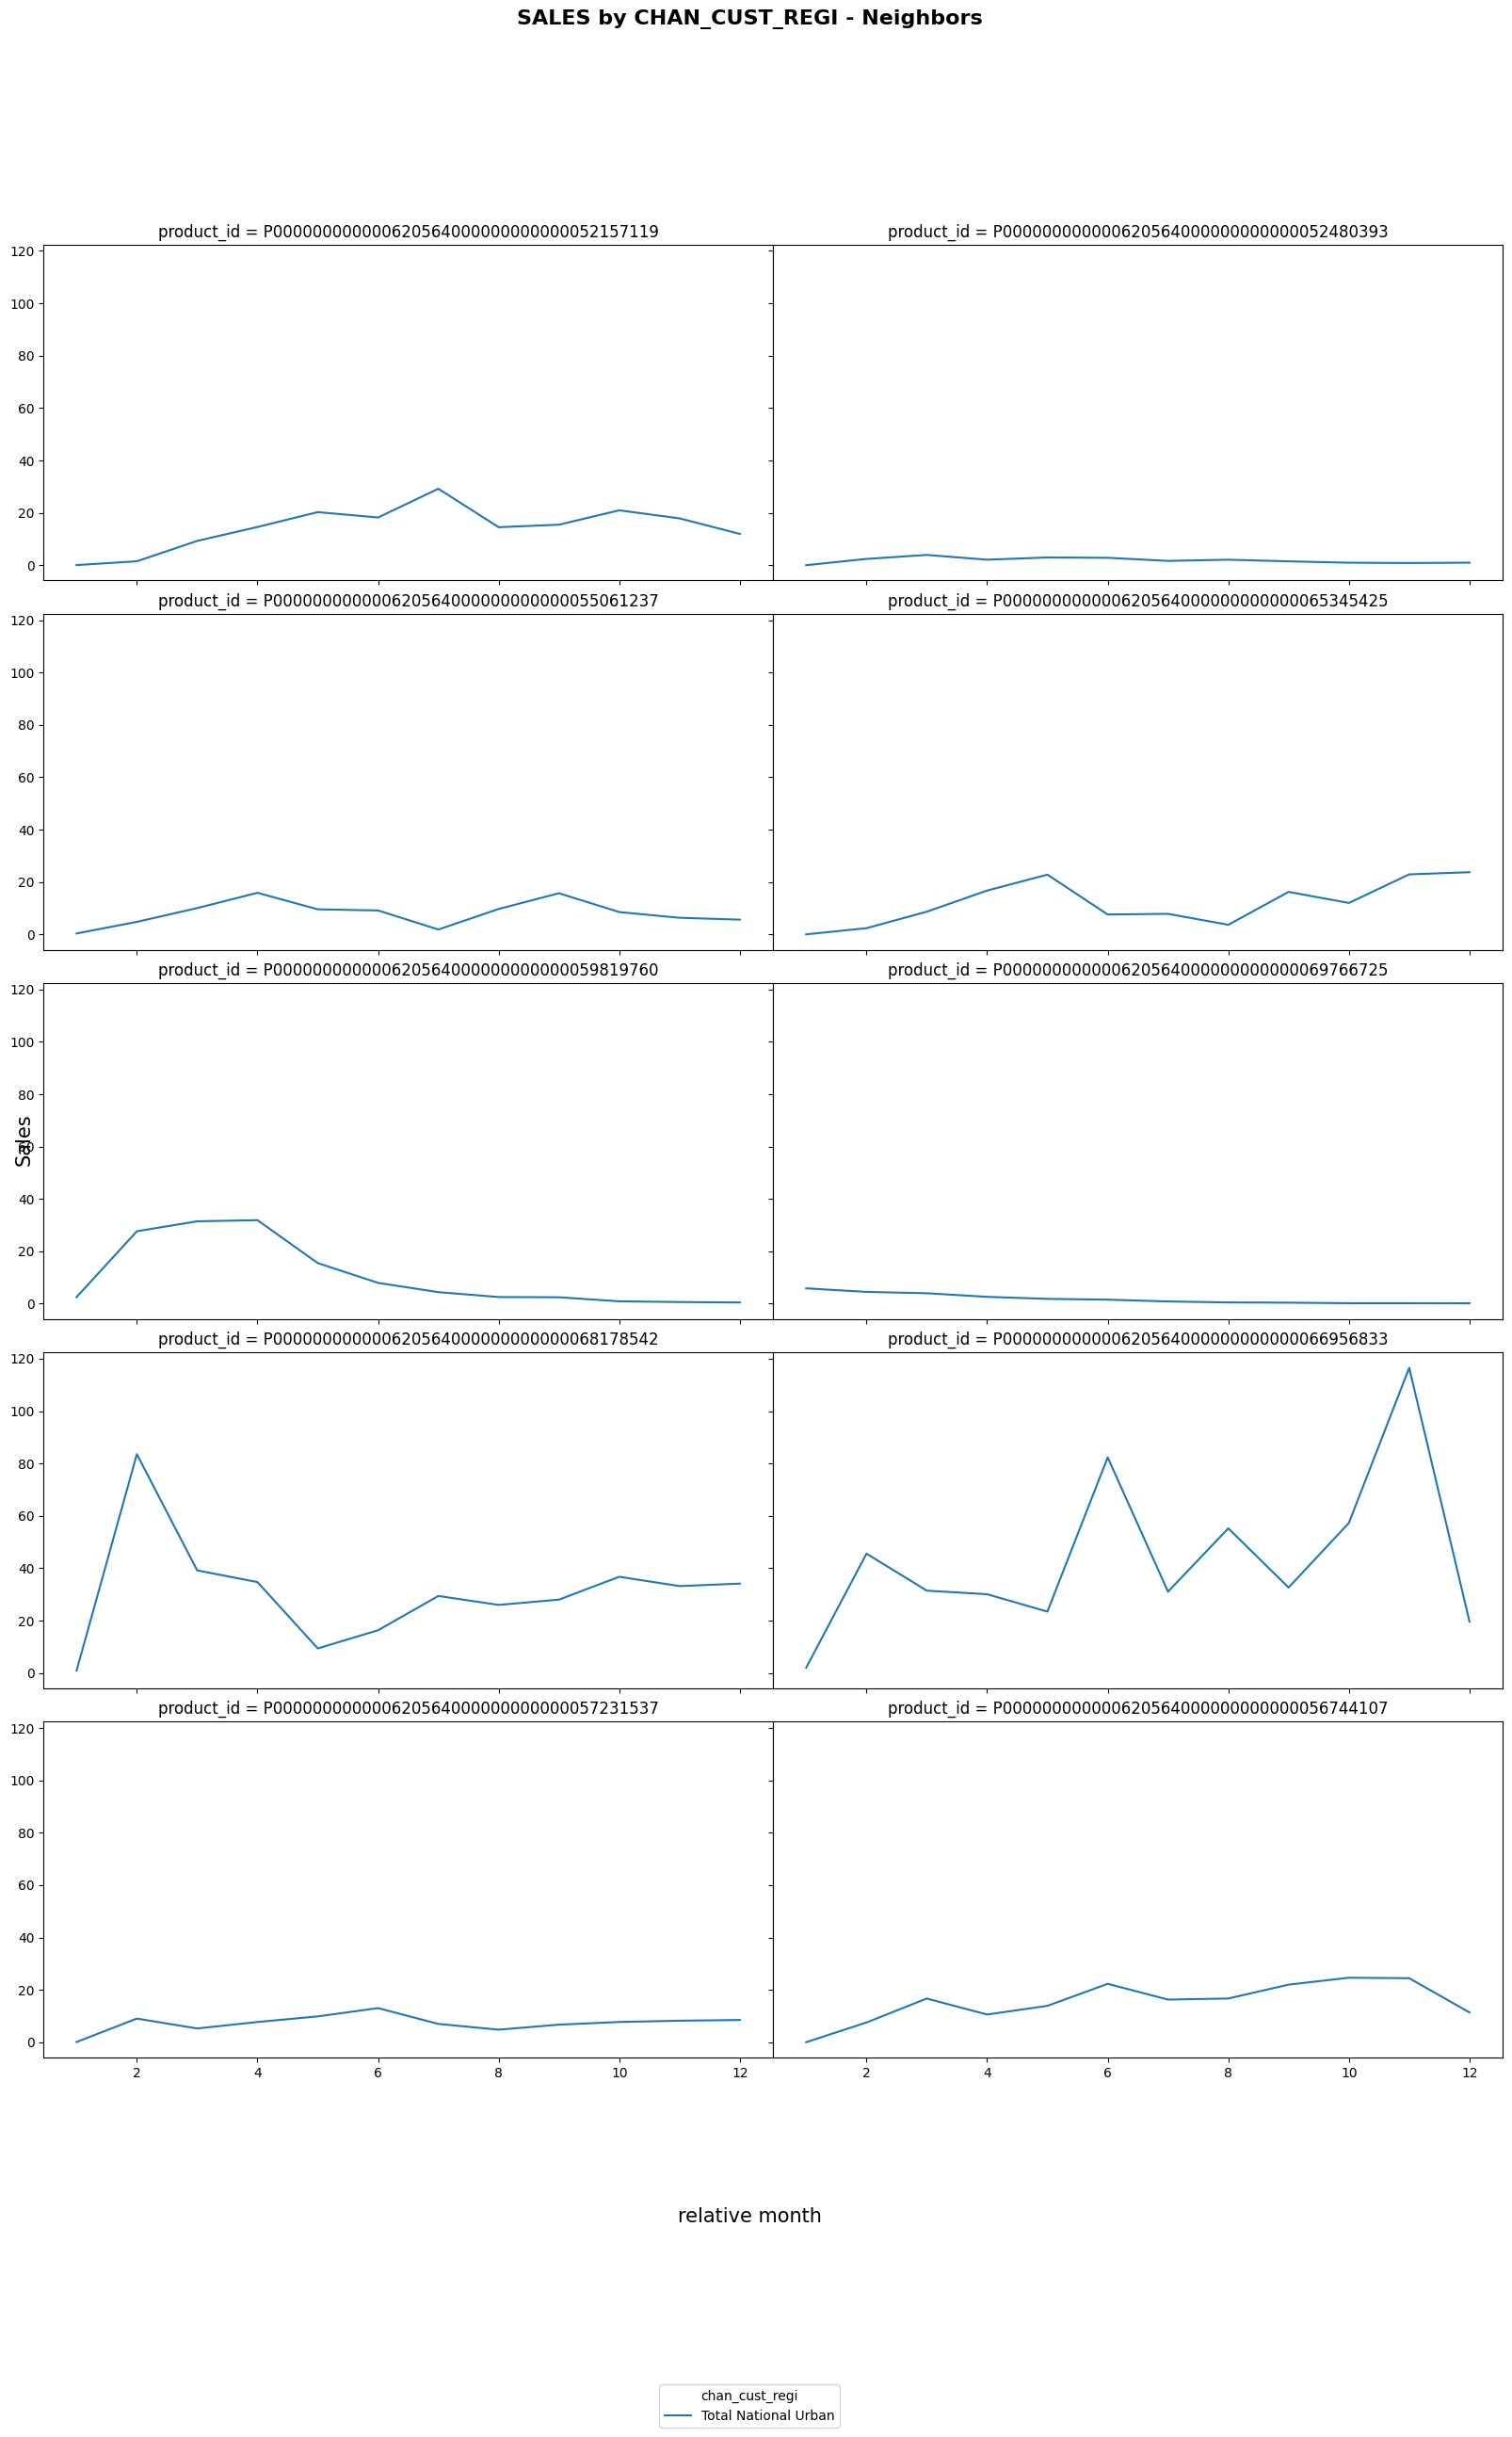

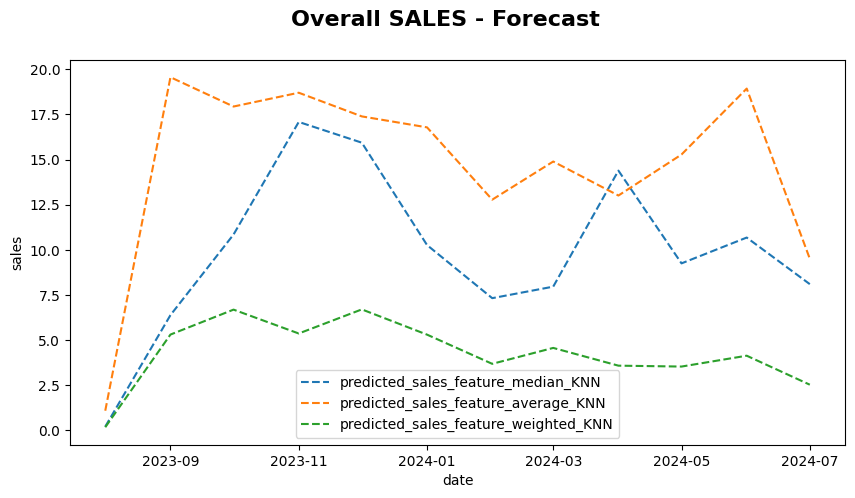

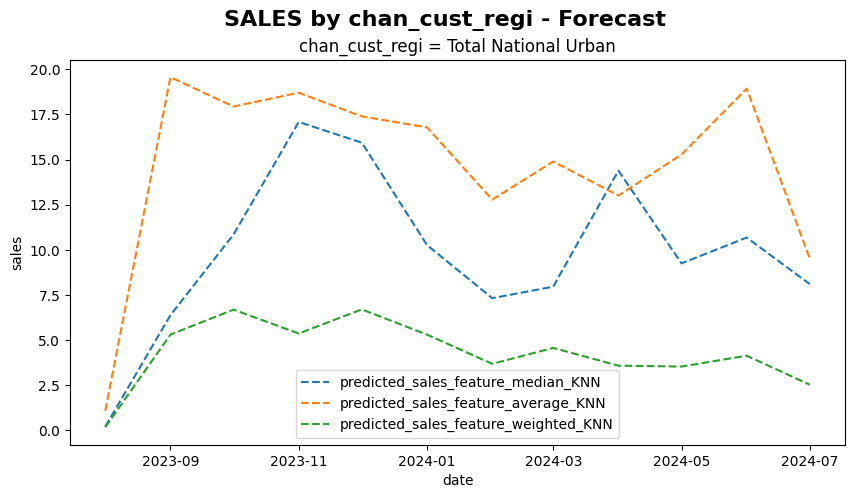

In [59]:
# Prepare dictionary for renaming in segmentation_prep_sku
num_mean_3_renaming = {}
for key in num_mean_2_renaming:
    num_mean_3_renaming[key] = str(key)[:10]

# Prepare dataset for forecasting
segmentation_prep_sku_knn = segmentation_prep_sku[:]
segmentation_prep_sku_knn = segmentation_prep_sku_knn.rename(columns={**num_mean_3_renaming})

# If not automatic we will just use specified number of k
if number_of_similar != 0:
    selected_product_k_neighbors = find_k_neighbors(segmentation_prep_sku_knn, assumptions, my_feat_weights, k=int(number_of_similar))
    display(pd.DataFrame([['Selected neighbors:', '']], columns=['Number of neighbors:', number_of_similar], index=['']))
    print()
    display_neighbors(selected_product_k_neighbors)
    print('From the most to the least similar.')
    predictions_k_neighbors = forecast_using_knn_results(selected_product_k_neighbors)
    plot_neighbors(selected_product_k_neighbors)
    plot_forecast(selected_product_k_neighbors)
else:
    find_k_neighbors(segmentation_prep_sku_knn, assumptions, my_feat_weights, k=15, find_best_k=True)
    
    selected_product_best_k_neighbors = find_k_neighbors(segmentation_prep_sku_knn, assumptions, my_feat_weights, k=best_k)
    display(pd.DataFrame([['Selected neighbors:', '']], columns=['Number of neighbors - only most similar:', best_k], index=['']))
    display_neighbors(selected_product_best_k_neighbors)
    print('From the most to the least similar.')
    predictions_best_k_neighbors = forecast_using_knn_results(selected_product_best_k_neighbors)
    plot_neighbors(selected_product_best_k_neighbors)
    plot_forecast(selected_product_best_k_neighbors)
    
    print()
    print()
    selected_product_5_neighbors = find_k_neighbors(segmentation_prep_sku_knn, assumptions, my_feat_weights, k=5)
    display(pd.DataFrame([['Selected neighbors:', '']], columns=['Number of neighbors:', '5'], index=['']))
    display_neighbors(selected_product_5_neighbors)
    print('From the most to the least similar.')
    predictions_5_neighbors = forecast_using_knn_results(selected_product_5_neighbors)
    plot_neighbors(selected_product_5_neighbors)
    plot_forecast(selected_product_5_neighbors)
    
    print()
    print()
    selected_product_10_neighbors = find_k_neighbors(segmentation_prep_sku_knn, assumptions, my_feat_weights, k=10)
    display(pd.DataFrame([['Selected neighbors:', '']], columns=['Number of neighbors:', '10'], index=['']))
    display_neighbors(selected_product_10_neighbors)
    print('From the most to the least similar.')
    predictions_10_neighbors = forecast_using_knn_results(selected_product_10_neighbors)
    plot_neighbors(selected_product_10_neighbors)
    plot_forecast(selected_product_10_neighbors)

## Export NPF_PREDICTION_OUTPUT.xlsx

In [60]:
# write to excel file - path the same as input dataset
path_to_file = input_dataset_path.rsplit('\\', 1)[0]


writer = pd.ExcelWriter(
    path_to_file + f'\\{assumptions.index[0]}_NPF_PREDICTION_OUTPUT.xlsx', engine="xlsxwriter")

assumptions_df.to_excel(
    writer, sheet_name='MY_ASSUMPTIONS', index=False)


if number_of_similar != 0:
    predictions_k_output = predictions_k_neighbors[0].copy().merge(
        forecast_rows[['date', 'relative_month']], left_on='date_forecast', right_on='date')
    predictions_k_output = predictions_k_output[['date', 'chan_cust_regi', 
                                                 'predicted_sales_feature_median_KNN',
                                                 'predicted_sales_feature_average_KNN',
                                                 'predicted_sales_feature_weighted_KNN', 'relative_month']]
    predictions_k_output['date'] = predictions_k_output['date'].dt.date
    
    predictions_k_output.to_excel(
        writer, sheet_name=f'FORECAST-GRANULAR_{number_of_similar}', index=False)

    sales_k_output = predictions_k_neighbors[2].merge(
        product_description_output, on='product_id')
    sales_k_output = sales_k_output[['product_id', 'product_name', 'manufacturer', 'chan_cust_regi', 
                                     'min_launch_date', 'date', 'relative_month', 'sales', 'norm_similarity']]
    sales_k_output['date'] = sales_k_output['date'].dt.date
    sales_k_output['min_launch_date'] = sales_k_output['min_launch_date'].dt.date

    sales_k_output.to_excel(
        writer, sheet_name=f'NEIGHBORS_{number_of_similar}', index=False)
else:
    predictions_best_k_output = predictions_best_k_neighbors[0].copy().merge(
        forecast_rows[['date', 'relative_month']], left_on='date_forecast', right_on='date')
    predictions_best_k_output = predictions_best_k_output[['date', 'chan_cust_regi', 
                                                           'predicted_sales_feature_median_KNN',
                                                           'predicted_sales_feature_average_KNN',
                                                           'predicted_sales_feature_weighted_KNN', 'relative_month']]
    predictions_best_k_output['date'] = predictions_best_k_output['date'].dt.date
    predictions_best_k_output.to_excel(
        writer, sheet_name='FORECAST-GRANULAR_MOST', index=False)

    sales_best_k_output = predictions_best_k_neighbors[2].merge(
        product_description_output, on='product_id')
    sales_best_k_output = sales_best_k_output[['product_id', 'product_name', 'manufacturer', 'chan_cust_regi', 
                                               'min_launch_date', 'date', 'relative_month', 'sales',
                                               'norm_similarity']]
    sales_best_k_output['date'] = sales_best_k_output['date'].dt.date
    sales_best_k_output['min_launch_date'] = sales_best_k_output['min_launch_date'].dt.date
    sales_best_k_output.to_excel(
        writer, sheet_name='NEIGHBORS_MOST', index=False)

    predictions_5_neighbors_output = predictions_5_neighbors[0].copy().merge(
        forecast_rows[['date', 'relative_month']], left_on='date_forecast', right_on='date')

    predictions_5_neighbors_output = predictions_5_neighbors_output[['date', 'chan_cust_regi', 
                                                                     'predicted_sales_feature_median_KNN',
                                                                     'predicted_sales_feature_average_KNN',
                                                                     'predicted_sales_feature_weighted_KNN', 
                                                                     'relative_month']]
    
    predictions_5_neighbors_output['date'] = predictions_5_neighbors_output['date'].dt.date
    predictions_5_neighbors_output.to_excel(
        writer, sheet_name='FORECAST-GRANULAR_5', index=False)

    sales_5_neighbors_output = predictions_5_neighbors[2].merge(
        product_description_output, on='product_id')
    sales_5_neighbors_output = sales_5_neighbors_output[['product_id', 'product_name', 'manufacturer', 'chan_cust_regi', 
                                                         'min_launch_date', 'date', 'relative_month', 'sales',
                                                         'norm_similarity']]
    sales_5_neighbors_output['date'] = sales_5_neighbors_output['date'].dt.date
    sales_5_neighbors_output['min_launch_date'] = sales_5_neighbors_output['min_launch_date'].dt.date
    sales_5_neighbors_output.to_excel(
        writer, sheet_name='NEIGHBORS_5', index=False)

    predictions_10_neighbors_output = predictions_10_neighbors[0].copy().merge(
        forecast_rows[['date', 'relative_month']], left_on='date_forecast', right_on='date')

    predictions_10_neighbors_output = predictions_10_neighbors_output[['date', 'chan_cust_regi', 
                                                                       'predicted_sales_feature_median_KNN',
                                                                       'predicted_sales_feature_average_KNN',
                                                                       'predicted_sales_feature_weighted_KNN', 
                                                                       'relative_month']]
    predictions_10_neighbors_output['date'] = predictions_10_neighbors_output['date'].dt.date
    predictions_10_neighbors_output.to_excel(
        writer, sheet_name='FORECAST-GRANULAR_10', index=False)

    sales_10_neighbors_output = predictions_10_neighbors[2].merge(
        product_description_output, on='product_id')
    sales_10_neighbors_output = sales_10_neighbors_output[['product_id', 'product_name', 'manufacturer', 'chan_cust_regi', 
                                                           'min_launch_date', 'date', 'relative_month', 'sales',
                                                           'norm_similarity']]
    sales_10_neighbors_output['date'] = sales_10_neighbors_output['date'].dt.date
    sales_10_neighbors_output['min_launch_date'] = sales_10_neighbors_output['min_launch_date'].dt.date
    sales_10_neighbors_output.to_excel(
        writer, sheet_name='NEIGHBORS_10', index=False)
    
writer.close()

## Finish

In [61]:
print(result)

Done
